In [1]:
import numpy as np
import scipy

from scipy import linalg
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cmap
import matplotlib
import os
import pandas as pd

import math

from numpy import absolute as A
from numpy import transpose as T

#import natsort

import cv2
import time
import matplotlib.pyplot as plt

import networkx as nx

import umap
import seaborn as sns

import statsmodels.api

from scipy.stats import ttest_ind

import pygad


from scipy import signal

In [448]:
#!pip install pygad

In [3]:
def weight_limits(W,W_freeze,tolerance,max_weight=None):

    W_trans = np.copy(W)
    W_sign_freeze = np.sign(W_freeze)
    
    if max_weight == None:
        W_freeze = W_freeze/np.max(np.max(A(W_freeze)))
    else: 
         W_freeze = W_freeze/max_weight
            
    #print(W_freeze)        

    W_trans_max_val = np.max(np.max(A(W_trans)))

    if W_trans_max_val > 0:
        W_trans = W_trans/np.max(np.max(A(W_trans))) 

    W_max=W_freeze + W_freeze*tolerance
    W_min=W_freeze - W_freeze*tolerance

    for wr in range(0,np.shape(W)[0]):
        for wc in range(0,np.shape(W)[1]):
            if A(W[wr,wc])>A(W_max[wr,wc]):
                W_trans[wr,wc] = W_max[wr,wc]
            if A(W[wr,wc])<A(W_min[wr,wc]):
                W_trans[wr,wc] = W_min[wr,wc] 
    W_trans = A(W_trans)            
    W_trans = W_trans*W_sign_freeze

    if np.max(np.max(A(W_trans))) > 0:
        W_trans =(W_trans/np.max(np.max(A(W_trans)))) * W_trans_max_val 
        #W_trans =W_trans * W_trans_max_val 
    
    return W_trans


def plant_joint(flex_rate,ext_rate,ang, ang_min, ang_max):
    
   # ang_max = 160
   # ang_min = 90
    
    #ang_min = 90 #last working b4 joint specific angles
    
    #ang_max = 160
    #ang_min = 20
    ang_vel_max = 20
    
    ang_vel = ext_rate - flex_rate
    if A(ang_vel) > ang_vel_max:
        ang_vel = ang_vel_max*np.sign(ang_vel)
    ang = ang + ang_vel
    

    if ang>A(ang_max):
        ang=ang_max*np.sign(ang)
    if ang<A(ang_min):
        ang=ang_min*np.sign(ang)      
        
    return ang, ang_vel    


def leg_construction (ang_0,ang_1,ang_2,Left_leg):
    
    
    D_0 = 3
    D_1 = 3
    D_2 = 5

    joint_positions_XY = np.random.randint(100,size=(3,2))

    pos_x_j2, pos_y_j2 = angle2pos(ang_2,D_2,Left_leg)
    
    ang_fc_1 = (180-ang_1)+ang_2 
    
    pos_x, pos_y = angle2pos(ang_fc_1,D_1,Left_leg)
    pos_x_j1 =  pos_x_j2 + pos_x
    pos_y_j1 =  pos_y_j2 + pos_y
    
    ang_fc_0 = (180-ang_0)+ang_fc_1
    
    pos_x, pos_y = angle2pos(ang_fc_0,D_0,Left_leg)
    pos_x_j0 =  pos_x_j1 + pos_x
    pos_y_j0 =  pos_y_j1 + pos_y
    
    joint_positions_XY[2,0] = pos_x_j2
    joint_positions_XY[2,1] = pos_y_j2
    joint_positions_XY[1,0] = pos_x_j1
    joint_positions_XY[1,1] = pos_y_j1
    joint_positions_XY[0,0] = pos_x_j0
    joint_positions_XY[0,1] = pos_y_j0
    
    return joint_positions_XY

def angle2pos (ang,D,Left_leg):
    ang = ang 

    ang_rad=np.radians(ang)#*(-1)
    #D_2=20

    pos_x = int(np.cos(ang_rad)*D)
    if Left_leg == True:
        pos_y = int(np.sin(ang_rad)*D)*(-1)
    else: pos_y = int(np.sin(ang_rad)*D)
    
    return pos_x, pos_y


def leg_collision(Xfc_left,Yfc_left,Xfc_right,Yfc_right):

    leg_collision = False

    eu_dist = np.sqrt((Xfc_left - Xfc_right)**2 + (Yfc_left - Yfc_right)**2) 


    if eu_dist<5:
        leg_collision = True
        
    return leg_collision   



def create_excit_net ():

    #ch=3
    #sense_sq_area = 26
    
    ch=1
    sense_sq_area = 20
    add_sensors = 2 + 12
    
    input_net_size = sense_sq_area*sense_sq_area*ch + add_sensors
    hidden_net_size_1 = 40
    numb_outputs = 13+4+4

    model_excit_net = Model_excitatory_net(input_net_size, hidden_net_size_1, numb_outputs)
    
    return model_excit_net


def solution2weights (solution):
    
    #channels = 3
    #sensors_numb = 26*26*channels
    
    channels = 1
    #sensors_numb = 6*6*channels
    sensors_numb = 20*20*channels + 2 + 12
    
    #sensors_numb = 100*100
    hidden_size = 40
    output_size = 13+4+4
    #print(sensors_numb*hidden_size)
    W_sens_hidden=np.reshape(solution[0:sensors_numb*hidden_size], (sensors_numb, hidden_size))
    
    W_hidden=np.reshape(solution[sensors_numb*hidden_size : sensors_numb*hidden_size+hidden_size*hidden_size], (hidden_size,hidden_size))
    
    W_hidden_out=np.reshape(solution[sensors_numb*hidden_size+hidden_size*hidden_size : sensors_numb*hidden_size+hidden_size*hidden_size+hidden_size*output_size],(hidden_size,output_size))
    
    Th_all = solution[18680:18680+467]
    Th_sens = Th_all[0:sensors_numb]
    Th_hidden = Th_all[sensors_numb : sensors_numb+hidden_size]
    Th_out = Th_all[sensors_numb+hidden_size : sensors_numb+hidden_size+output_size]
    
    return W_sens_hidden,W_hidden,W_hidden_out,Th_sens,Th_hidden,Th_out


def create_all_learnable_params(solution):
    
    W_mat_13A_freeze = np.zeros((2,2))
    W_mat_13B_freeze = np.zeros((2,1))
    W_13A_MN_freeze = np.zeros((2,6))
    #W_mat_SN_freeze = np.zeros((6,1))
    W_mat_SN_13A_freeze = np.zeros((6,2))
    W_mat_SN_MNs_freeze = np.zeros((6,6))

    #W_mat_13A_freeze[0,1]=-64
    #W_mat_13A_freeze[1,0]=-82
    W_mat_13A_freeze[0,1]=-559
    W_mat_13A_freeze[1,0]=-488
    
    W_mat_13B_freeze[0,0]=-413
    W_mat_13B_freeze[1,0]=-160

   # W_13A_MN_freeze[0,1:3] = -488
   # W_13A_MN_freeze[1,4:6] = -612
   # W_13A_MN_freeze[0,0] = -612
   # W_13A_MN_freeze[1,3] = -488
    
    W_13A_MN_freeze[0,1:3] = -1525
    W_13A_MN_freeze[1,4:6] = -1594
    W_13A_MN_freeze[0,0] = -1594
    W_13A_MN_freeze[1,3] = -1525

    W_mat_SN_13A_freeze[0:3,0] = 526
    W_mat_SN_13A_freeze[3:6,0] = 153
    W_mat_SN_13A_freeze[3:6,1] = 48

    W_mat_SN_MNs_freeze[0:3,3:6] = 244
    W_mat_SN_MNs_freeze[3:6,0:3] = 548

    W_mat_13B = np.reshape(solution[0:2],(2,1))
    W_mat_13A = np.reshape(solution[2:2+4],(2,2))
    W_13A_MN = np.reshape(solution[6:6+12],(2,6))
    W_mat_SN = np.reshape(solution[18:18+6],(6,1))
    W_mat_SN_13A = np.reshape(solution[24:24+12],(6,2))
    W_mat_SN_MNs = np.reshape(solution[36:36+36],(6,6))

    W_mat_13B = weight_limits(W_mat_13B,W_mat_13B_freeze,0.2) 
    W_mat_13A = weight_limits(W_mat_13A,W_mat_13A_freeze,0.2,max_weight=1594) 
    W_13A_MN  = weight_limits(W_13A_MN,W_13A_MN_freeze,0.2,max_weight=1594)
    #W_mat_SN = weight_limits(W_mat_SN,W_mat_SN_freeze,0.2) 
    W_mat_SN_13A  = weight_limits(W_mat_SN_13A,W_mat_SN_13A_freeze,0.2,max_weight=548)
    W_mat_SN_MNs  = weight_limits(W_mat_SN_MNs,W_mat_SN_MNs_freeze,0.2,max_weight=548)

    Th_vec_13B = np.reshape(solution[72:72+2],(2,1))
    Th_vec_13A = np.reshape(solution[74:74+2],(2,1))
    Th_MNs = np.reshape(solution[76:76+6],(6,1))
    Th_SNs = np.reshape(solution[82:82+6],(6,1))
    
    return W_mat_13B, W_mat_13A, W_13A_MN, W_mat_SN, W_mat_SN_13A, W_mat_SN_MNs,Th_vec_13B, Th_vec_13A,  Th_MNs, Th_SNs



def create_energy_field(m1,m2,cov_size_1,cov_size_2,tile_size):
    
    #energy_field = np.zeros((100,100))
    energy_field = np.zeros((tile_size,tile_size))
    # Create a grid of x and y values
    x = np.linspace(-5, 5, tile_size)
    y = np.linspace(-5, 5, tile_size)
    x, y = np.meshgrid(x, y)

    # Define the parameters of the Gaussian distribution
    mean = [m1, m2]
    covariance = [[cov_size_1, 0], [0, cov_size_2]]  # Identity covariance matrix

    # Calculate the Gaussian values
    gaussian_values = np.exp(-0.5 * (np.square(x - mean[0]) + np.square(y - mean[1])) / covariance[0][0])

    # Create the 100 by 100 array with Gaussian values
    array_2d = gaussian_values


    energy_field = array_2d
    #energy_field[0:tile_size,0:tile_size] = array_2d
    #energy_field[0:tile_size,tile_size:tile_size*2] = array_2d
    #energy_field[tile_size:tile_size*2,0:tile_size] = array_2d
    #energy_field[tile_size:tile_size*2,tile_size:tile_size*2] = array_2d
    
    return energy_field

def update_environment(body_field,joint_positions_XY):
    
    joint_size = 2
    center_pos=int(np.shape(body_field)[0]/2)

    env_cube = np.zeros((body_field.shape[0],body_field.shape[1],3))
    #rgbArray[..., 0] = uni_mat[:,:,2]*255
    env_cube[..., 1] = body_field*1
    #rgbArray[..., 2] = uni_mat[:,:,0]*255
    
    for j in range(0,1):
    
        env_cube[center_pos+joint_positions_XY[j,0]:center_pos+joint_size+joint_positions_XY[j,0],
                 center_pos+joint_positions_XY[j,1]:center_pos+joint_size+joint_positions_XY[j,1],
                 2] =1
        
    #env_cube[center_pos:center_pos+joint_size,
    #         center_pos:center_pos+joint_size,
    #         2] =1
    
    return env_cube



def sense(pos_x,pos_y,center_pos,env_cube):

    ch = 3
    size_sense_area = 6
    half_size = int(size_sense_area/2)

    sense_cent_x = center_pos+pos_x 
    sense_cent_y = center_pos+pos_y 

    sense_area = env_cube[sense_cent_x-half_size : sense_cent_x+half_size,
                          sense_cent_y-half_size : sense_cent_y+half_size,
                          :]
    
    return sense_area

def sense_body(body_field):

    sense_area = body_field[5:25,5:25]    
    return sense_area

def create_stim_sig(intensity,pulse_len,silence_per):

    stim_sig = np.zeros((1,time_tot))
    #intensity = 10
    #pulse_len=20

    for i in range(0,np.shape(stim_sig)[1],pulse_len*silence_per):
        stim_sig[0,i:i+pulse_len] = intensity
        
    return stim_sig  

def random_sign():
    if np.random.rand()>0.5:
        rs=1
    else:
        rs=-1
        
    return rs    


def render_video(dust_field,joint_positions_XY_L,joint_positions_XY_R,
                 A_vec_13A_L,A_vec_13A_R,
                 MN_L,MN_R, 
                 stim): 
    
    joint_size = 2
    center_pos = int(np.shape(dust_field)[0]/2)
    
#plt.plot(CF_tot[13,lim1:lim2],'b') #PL
#plt.plot(CF_tot[14,lim1:lim2],'r') #PR
#plt.plot(CF_tot[10,lim1:lim2],'cyan') #ML
#plt.plot(CF_tot[12,lim1:lim2],'orange') #MR
#plt.plot(CF_tot[9,lim1:lim2],'pink')#dl
#plt.plot(CF_tot[11,lim1:lim2],'purple')

#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
    
    color_mat_L = np.zeros((3,3))
    color_mat_L[0,:] = [255,255,0]
    color_mat_L[1,:] = [203,192,255]
    color_mat_L[2,:] = [255,0,0]
    
    color_mat_R = np.zeros((3,3))
    color_mat_R[0,:] = [128,0,128]
    color_mat_R[1,:] = [0,165,255]
    color_mat_R[2,:] = [0,0,255]

    rgbArray = np.zeros((dust_field.shape[0],dust_field.shape[1],3), 'uint8')
    #rgbArray[..., 0] = uni_mat[:,:,2]*255
    rgbArray[..., 1] = dust_field*255
    #rgbArray[..., 2] = uni_mat[:,:,0]*255
    
    for j in range(0,3):
    
        rgbArray[center_pos+joint_positions_XY_L[j,0]:center_pos+joint_size+joint_positions_XY_L[j,0],
                 center_pos+joint_positions_XY_L[j,1]:center_pos+joint_size+joint_positions_XY_L[j,1],
                 :] = color_mat_L[j,:]
        
    for j in range(0,3):
    
        rgbArray[center_pos+joint_positions_XY_R[j,0]:center_pos+joint_size+joint_positions_XY_R[j,0],
                 center_pos+joint_positions_XY_R[j,1]:center_pos+joint_size+joint_positions_XY_R[j,1],
                 :] = color_mat_R[j,:]    
        
    rgbArray[center_pos:center_pos+joint_size,
             center_pos:center_pos+joint_size,
             2] =250
    
    ########### draw 13A network #########
    
    node_size = int(joint_size/2)
    
   # rgbArray[20:20+node_size ,
    #         22:22+node_size ,
    #         1] = 0
    
    rgbArray[19:26,
             10:23,
             1] = 0
    
    rgbArray[20:20+node_size ,
             22:22+node_size ,
             2] = int(A_vec_13A_R[0,0])
    
    rgbArray[25:25+node_size ,
             22:22+node_size ,
             2] = int(A_vec_13A_R[1,0])
    
    
        
    rgbArray[20:20+node_size,
             10:10+node_size,
             1] = 0
    
    rgbArray[20:20+node_size,
             10:10+node_size,
             0] = int(A_vec_13A_L[0,0])
    
    rgbArray[25:25+node_size,
             10:10+node_size,
             0] = int(A_vec_13A_L[1,0])
    

   ############ MN net ################## 
    
    
    rgbArray[21:21+node_size,
             13:13+node_size,
             0] = int(MN_L[0])
    
    rgbArray[23:23+node_size,
             13:13+node_size,
             0] = int(MN_L[1])
    
    rgbArray[25:25+node_size,
             13:13+node_size,
             0] = int(MN_L[2]) 
    
        
    rgbArray[21:21+node_size,
             15:15+node_size,
             0] = int(MN_L[3])
    
    rgbArray[23:23+node_size,
             15:15+node_size,
             0] = int(MN_L[4])
    
    rgbArray[25:25+node_size,
             15:15+node_size,
             0] = int(MN_L[5]) 
    
        
    rgbArray[21:21+node_size,
             17:17+node_size,
             2] = int(MN_R[0])
    
    rgbArray[23:23+node_size,
             17:17+node_size,
             2] = int(MN_R[1])
    
    rgbArray[25:25+node_size,
             17:17+node_size,
             2] = int(MN_R[2]) 
    
        
    rgbArray[21:21+node_size,
             19:19+node_size,
             2] = int(MN_R[3])
    
    rgbArray[23:23+node_size,
             19:19+node_size,
             2] = int(MN_R[4])
    
    rgbArray[25:25+node_size,
             19:19+node_size,
             2] = int(MN_R[5]) 
    
    
   ############# stumulus light ###################### 
    
    rgbArray[5:5+joint_size,
             10:10+joint_size,
             2] = np.abs(int(stim*250))
    
    
    ##############################################
    
    
    im_to_show = rgbArray
    im_to_show = cv2.resize(im_to_show, (600, 600)) 
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale=0.4    
    
    A13_L_text = 'A13_L   MN_L       MN_R   A13_R'
    org = (190, 370)
    color = (0,165,255)
    thickness = 1
    im_to_show = cv2.putText(im_to_show, A13_L_text, org, font, fontScale,
                             color, thickness, cv2.LINE_AA)

    cv2.imshow('test_mat',im_to_show)

    plt.clf()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        pass
    
    
    return im_to_show

def get_deriv_mat (feat1,feat2,time_start,time_end):
    
    #feat1 = feat1 - np.min(np.min(feat1))
    #feat2 = feat2 - np.min(np.min(feat2))
        
    feat1 = feat1/np.max(np.max(feat1))
    feat2 = feat2/np.max(np.max(feat2))

    dd1_mat = np.zeros((100,100))
    dd2_mat = np.zeros((100,100))

    feat_dd1 = np.append(np.diff(feat1),0)
    feat_dd2 = np.append(np.diff(feat2),0)

    for t in range(time_start,time_end):

        r = int(feat1[t]*100) - 1
        c = int(feat2[t]*100) - 1

        #print(r,c)

        dd1_mat[r,c] = feat_dd1[t]
        dd2_mat[r,c] = feat_dd2[t]
        
    return dd1_mat, dd2_mat  

In [4]:
class Model_excitatory_net ():
    
    def __init__(self,input_net_size, hidden_net_size_1, numb_outputs):
        
        channels = 1
        

        self.sens_layer = np.zeros((input_net_size*channels))        
        self.hidden_layer = np.zeros((hidden_net_size_1))   
        self.out_layer = np.zeros((numb_outputs))
        
        self.sens_layer_th = np.zeros((input_net_size*channels))        
        self.hidden_layer_th = np.zeros((hidden_net_size_1))   
        self.out_layer_th = np.zeros((numb_outputs))
        
        self.W_sens_hidden = np.zeros((input_net_size*channels,hidden_net_size_1)) +0.5
        self.W_hidden = np.zeros((hidden_net_size_1,hidden_net_size_1))
        self.W_hidden_out = np.zeros((hidden_net_size_1,numb_outputs))
        
        #self.W_hidden_FF = np.zeros((hidden_net_size_1,hidden_net_size_FF))
        #self.W_hidden_out_FF = np.zeros((hidden_net_size_FF,numb_outputs))
        
        self.epsilon = -0
        

    def run_excit_network(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        
        self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) #+ N_hidden*self.epsilon
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer)
        
        self.out_layer = np.matmul(M1,M2) #+ N_out*self.epsilon
        
        #self.epsilon = self.out_layer[6]
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state
    
    def run_excit_network_1(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        #trans_state = trans_state - self.sens_layer_th 
        #trans_state[trans_state<0]=0
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        #self.hidden_layer = self.hidden_layer - self.hidden_layer_th
        #self.hidden_layer[self.hidden_layer<0]=0
        
        self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) + N_hidden*self.epsilon
        #self.hidden_layer = self.hidden_layer - self.hidden_layer_th
        self.hidden_layer[self.hidden_layer<0]=0
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer)
        
        self.out_layer = np.matmul(M1,M2) + N_out*self.epsilon
        #self.out_layer = self.out_layer - self.out_layer_th
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state
    
    def run_excit_network_FF(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        self.hidden_layer[self.hidden_layer<0]=0
        
        #self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) #+ N_hidden*self.epsilon
        #self.hidden_layer[self.hidden_layer<0]=0
        
        self.hidden_layer_FF = np.matmul(self.W_hidden_FF, self.hidden_layer) 
        self.hidden_layer_FF[self.hidden_layer_FF<0]=0
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer_FF)
        
        self.out_layer = np.matmul(M1,M2) #+ N_out*self.epsilon
        
        #self.epsilon = self.out_layer[6]
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state

In [5]:

def run_network(solution,time_tot,stim_sig =[],
                stim_13A = True,
                stim_SNs = False,
                display_movie=False,record_data=False):
    

    W_mat_13B_L, W_mat_13A_L, W_13A_MN_L, W_mat_SN_L, W_mat_SN_13A_L, W_mat_SN_MNs_L, Th_vec_13B_L, Th_vec_13A_L, Th_MNs_L, Th_SNs_L = create_all_learnable_params(solution[0:88])
    W_mat_13B_R, W_mat_13A_R, W_13A_MN_R, W_mat_SN_R, W_mat_SN_13A_R, W_mat_SN_MNs_R, Th_vec_13B_R, Th_vec_13A_R, Th_MNs_R, Th_SNs_R = create_all_learnable_params(solution[88:88*2])

    
    remaining_ration = 5/20
    
    #W_mat_13A_L=W_mat_13A_L*0
    #W_13A_MN_L=W_13A_MN_L*0 
    #W_mat_SN_L=W_mat_SN_L*0 
    #W_mat_SN_13A_L=W_mat_SN_13A_L*0
    #W_mat_SN_MNs_L=W_mat_SN_MNs_L*0 #remove sens. feedback to MN
    #W_mat_13A_R=W_mat_13A_R*0
    #W_13A_MN_R=W_13A_MN_R*0 
    #W_mat_SN_R=W_mat_SN_R*0 
    #W_mat_SN_13A_R=W_mat_SN_13A_R*0
    #W_mat_SN_MNs_R=W_mat_SN_MNs_R*0 
    
    #W_mat_13A_L[1,0] = 0 #remove one recip. 13A connection
    #W_mat_13A_L[0,1] = 0 #remove one recip. 13A connection
    #W_13A_MN_L[0,:]=0 #remove 3/6 13A to MN connections
    #W_13A_MN_L[1,:]=0 #remove 3/6 13A to MN connections
    #W_mat_SN_MNs_L[0:3,:]=0
    #W_mat_SN_MNs_L[3:6,:]=0
    
    #W_mat_13A_R[1,0] = 0 #remove one recip. 13A connection
    #W_mat_13A_R[0,1] = 0 #remove one recip. 13A connection
    #W_mat_13A_R[1,0] = W_mat_13A_R[1,0] -W_mat_13A_R[1,0]*remaining_ration 
    #W_mat_13A_R[0,1] = W_mat_13A_R[0,1] -W_mat_13A_R[0,1]*remaining_ration 
    
    #W_13A_MN_R[0,:]=0 #remove 3/6 13A to MN connections
    #W_13A_MN_R[1,:]=0 #remove 3/6 13A to MN connections
    #W_mat_SN_MNs_R[0:3,:]=0
    #W_mat_SN_MNs_R[3:6,:]=0
    
    remove_excitatory_network = False
    
    ##################################
    
    A_vec_13B_L =np.zeros((2,1))
    A_vec_13A_L =np.zeros((2,1))
    MNs_L = np.zeros((6,1)) 
    SNs_L = np.zeros((6,1)) 

    A_vec_13B_R =np.zeros((2,1))
    A_vec_13A_R =np.zeros((2,1))
    MNs_R = np.zeros((6,1)) 
    SNs_R = np.zeros((6,1)) 

    #max_rate = 2000000 # until m42
    #max_rate = 200 #until m59
    
    max_rate_MN=200
    max_rate_SN=200
    max_rate_13A = 2500
    max_rate_13B = 2500
   # max_rate_MN=solution[-3]
   # max_rate_SN=solution[-2]
   # max_rate_13A = solution[-1]

    
    
    eff_copy_L = np.squeeze(MNs_L,axis=1)*0
    eff_copy_R = np.squeeze(MNs_R,axis=1)*0

    ####################EXCIT NET ###########

    #solution_excit = solution[84*2:np.shape(solution)[0]-3]
    solution_excit = solution[(88)*2:np.shape(solution)[0]] #m52 and below
    #solution_excit = solution[84*2 : 84*2+18680]
    W_sens_hidden,W_hidden,W_hidden_out,Th_sens,Th_hidden,Th_out = solution2weights (solution_excit)
    #print(np.shape(Th_sens),np.shape(Th_hidden),np.shape(Th_out))

    model_excit_net = create_excit_net ()

    model_excit_net.W_sens_hidden = W_sens_hidden
    model_excit_net.W_hidden = W_hidden
    model_excit_net.W_hidden_out = W_hidden_out
    
    model_excit_net.sens_layer_th = Th_sens
    model_excit_net.hidden_layer_th = Th_hidden
    model_excit_net.out_layer_th = Th_out

    #####################################
    
    
    
    if len(stim_sig) == 0:
        stim_sig = np.zeros((1,time_tot))
        

    N = np.random.uniform(-1,1)
    #epsilon = W[1,8]*0
    epsilon=0
    min_epsilon = 0
    epsilon_MN = 0

    A_vec_13A_rec_L = np.zeros((2,time_tot))
    A_vec_13B_rec_L = np.zeros((2,time_tot))
    A_vec_13A_rec_R = np.zeros((2,time_tot))
    A_vec_13B_rec_R = np.zeros((2,time_tot))
    
    MN_rec_L = np.zeros((6,time_tot))
    SN_rec_L = np.zeros((6,time_tot))
   
    MN_rec_R = np.zeros((6,time_tot))
    SN_rec_R = np.zeros((6,time_tot))
    angles_rec_L = np.zeros((3,time_tot))
    angles_rec_R = np.zeros((3,time_tot))
    
    out_excit_rec_L = np.zeros((6,time_tot))
    out_excit_rec_R = np.zeros((6,time_tot))
    
    out_excit_rec = np.zeros((21,time_tot))
    
    vel_rec = np.zeros((2,time_tot))
    
    HL_act_rec = np.zeros((40,time_tot))

    #plant params and evn initiation ##############

    #int_ang=90
    ang_0_L=np.random.randint(179)
    ang_1_L=np.random.randint(179)
    ang_2_L=np.random.randint(179)

    ang_0_R=np.random.randint(179)
    ang_1_R=np.random.randint(179)
    ang_2_R=np.random.randint(179)

    joint_positions_XY_L = leg_construction (ang_0_L,ang_1_L,ang_2_L,Left_leg=True) 
    joint_positions_XY_R = leg_construction (ang_0_R,ang_1_R,ang_2_R,Left_leg=False) 
 
   # joint_positions_XY_L_rec = np.zeros((2,time_tot))
   # joint_positions_XY_R_rec = np.zeros((2,time_tot))

    joint_positions_XY_L_rec = np.zeros((3,2,time_tot))
    joint_positions_XY_R_rec = np.zeros((3,2,time_tot))

    
    pos_x_L = 0
    pos_y_L = 0
    pos_x_R = 0
    pos_y_R = 0
    pos_x_L_prev = 0
    pos_y_L_prev = 0
    pos_x_R_prev = 0
    pos_y_R_prev = 0


    body_field_size = 26+6
    
    body_field = create_energy_field(0,
                         0,
                         4,
                         4,
                         body_field_size)*1
    
    center_pos=int(np.shape(body_field)[0]/2)

    tot_dust = np.sum(np.sum(body_field))
    dust_removed_per_sweep = 0.5 #4 in v38; 2 in m49
    dust_accum_L = 0
    dust_accum_R = 0
    max_dust_accum = 2 #4 in v38
    dust_removed = 0
    dust_removed_per_leg_rub =0.5
    
    min_vel_for_dust_removal = 1
    
    ang_vel_max = 90
    
    energy_loss = 0
    
    env_cube=update_environment(body_field,joint_positions_XY_L)


    st_rec_cube = np.zeros((body_field_size,body_field_size,6))

    #######################################
    
    if display_movie == True:

        result = cv2.VideoWriter('filename.avi',  
                                 cv2.VideoWriter_fourcc(*'MJPG'), 
                                 10, (600,600)) 

    ###########################################
    
    for t in range(0,time_tot):
        
        sense_area = sense_body(body_field)
        sense_area = sense_area.flatten()
        
        input_to_net = T(np.hstack((sense_area,
                                    dust_accum_L/max_dust_accum, 
                                    dust_accum_R/max_dust_accum, 
                                    eff_copy_L, eff_copy_R)))
   
        #print(input_to_net)
        #out_excit = model_excit_net.run_excit_network(input_to_net)
        out_excit = model_excit_net.run_excit_network_1(input_to_net*0.01)
        #out_excit = model_excit_net.run_excit_network_FF(input_to_net)
        
        out_excit[out_excit>max_rate_13A] = max_rate_13A
        out_excit[out_excit<0] = 0
        
        if remove_excitatory_network == True:
        
            out_excit =  out_excit*0+1 #make excit. inputs CONSTANT
        
        
        out_excit_L = out_excit[0:6]*1
        out_excit_R = out_excit[7:13]*1
        #out_excit_L = out_excit_R
        
        out_excit_13A_L =  out_excit[13:15]*1
        out_excit_13A_R =  out_excit[15:17]*1
        #out_excit_13A_L = out_excit_13A_R
        
        out_excit_13B_L =  out_excit[17:19]*1
        out_excit_13B_R =  out_excit[19:21]*1
        
        out_excit_rec_L[:,t] = out_excit_L
        out_excit_rec_R[:,t] = out_excit_R
        
        out_excit_rec[:,t] = out_excit
        
        A_vec_13B_th_L = A_vec_13B_L - Th_vec_13B_L
        A_vec_13B_th_L[A_vec_13B_th_L<0]=0        
        A_vec_13B_L = A_vec_13B_L + A_vec_13B_th_L
        #A_vec_13B_L = A_vec_13B_L + np.expand_dims(out_excit_13B_L,axis=1) 
        A_vec_13B_L = np.expand_dims(out_excit_13B_L,axis=1) 
        A_vec_13B_L[A_vec_13B_L<0]=0
        A_vec_13B_L[A_vec_13B_L>max_rate_13B] =max_rate_13B

        A_vec_13A_th_L = A_vec_13A_L - Th_vec_13A_L
        A_vec_13A_th_L[A_vec_13A_th_L<0]=0
        A_vec_13A_th_L = np.matmul(W_mat_13A_L,A_vec_13A_th_L)
        
        A_vec_13A_L = A_vec_13A_L + A_vec_13A_th_L
        A_vec_13A_L =  A_vec_13A_L + np.matmul(T(W_mat_13B_L),A_vec_13B_L) 
        A_vec_13A_L = A_vec_13A_L + np.expand_dims(out_excit_13A_L,axis=1)  
        
        if stim_13A == True:
            A_vec_13A_L = A_vec_13A_L + stim_sig[0,t]
        
        A_vec_13A_L[A_vec_13A_L<0]=0
        A_vec_13A_L[A_vec_13A_L>max_rate_13A] =max_rate_13A
        
        A_vec_13B_th_R = A_vec_13B_R - Th_vec_13B_R
        A_vec_13B_th_R[A_vec_13B_th_R<0]=0        
        A_vec_13B_R = A_vec_13B_R + A_vec_13B_th_R
        #A_vec_13B_R = A_vec_13B_R + np.expand_dims(out_excit_13B_R,axis=1) 
        A_vec_13B_R = np.expand_dims(out_excit_13B_R,axis=1) 
        A_vec_13B_R[A_vec_13B_R<0]=0
        A_vec_13B_R[A_vec_13B_R>max_rate_13B] =max_rate_13B

        A_vec_13A_th_R = A_vec_13A_R - Th_vec_13A_R
        A_vec_13A_th_R[A_vec_13A_th_R<0]=0
        A_vec_13A_th_R = np.matmul(W_mat_13A_R,A_vec_13A_th_R)
        A_vec_13A_R = A_vec_13A_R + A_vec_13A_th_R
        A_vec_13A_R =  A_vec_13A_R + np.matmul(T(W_mat_13B_R),A_vec_13B_R)  
        A_vec_13A_R = A_vec_13A_R + np.expand_dims(out_excit_13A_R,axis=1) 
        
        if stim_13A == True:
            A_vec_13A_R =  A_vec_13A_R + stim_sig[0,t]
            #A_vec_13A_R[0,0] =  A_vec_13A_R[0,0] + stim_sig[0,t]

        A_vec_13A_R[A_vec_13A_R<0]=0
        A_vec_13A_R[A_vec_13A_R>max_rate_13A] =max_rate_13A
        

        HL_act_rec[:,t] = model_excit_net.hidden_layer 

        ######### RIGHT

        #print(A_vec_13A_R.shape)
        #print(MNs_R.shape)
        #MNs_R = MNs_R + np.expand_dims(out_excit[7:13],axis=1) 
        MNs_R = MNs_R + np.expand_dims(out_excit_R,axis=1) 
        MNs_R = MNs_R + np.matmul(T(W_13A_MN_R),A_vec_13A_R) #+ noise_vec
        MNs_R = MNs_R - Th_MNs_R
        
        MNs_R = MNs_R + np.random.uniform(-1, 1, size=[6,1])*epsilon_MN 
        
        MNs_R[MNs_R>max_rate_MN] = max_rate_MN 
        MNs_R[MNs_R<0]=0
        #print(MNs_R.shape)
        
        #MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)

        ext_rate_0_R = MNs_R[0,0]
        flex_rate_0_R = MNs_R[3,0]
        ext_rate_1_R = MNs_R[1,0]
        flex_rate_1_R = MNs_R[4,0]
        ext_rate_2_R = MNs_R[2,0]
        flex_rate_2_R = MNs_R[5,0]

        ang_0_R,ang_vel_0_R = plant_joint(flex_rate_0_R,ext_rate_0_R,ang_0_R,100,180)
        ang_1_R,ang_vel_1_R = plant_joint(flex_rate_1_R,ext_rate_1_R,ang_1_R,100,180)
        ang_2_R,ang_vel_2_R = plant_joint(flex_rate_2_R,ext_rate_2_R,ang_2_R,80,120)

        joint_positions_XY_R = leg_construction (ang_0_R,ang_1_R,ang_2_R,Left_leg=False) 

        ##### LEFT


        MNs_L = MNs_L + np.expand_dims(out_excit_L,axis=1) 
        MNs_L = MNs_L + np.matmul(T(W_13A_MN_L),A_vec_13A_L) #+ noise_vec
        MNs_L = MNs_L - Th_MNs_L
        
        MNs_L = MNs_L + np.random.uniform(-1, 1, size=[6,1])*epsilon_MN 

        MNs_L[MNs_L>max_rate_MN] = max_rate_MN 
        MNs_L[MNs_L<0]=0
        
        #print(MNs_L)
        #print(MNs_L.shape)
        
        #MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)

        ext_rate_0_L = MNs_L[0,0]
        flex_rate_0_L = MNs_L[3,0]
        ext_rate_1_L = MNs_L[1,0]
        flex_rate_1_L = MNs_L[4,0]
        ext_rate_2_L = MNs_L[2,0]
        flex_rate_2_L = MNs_L[5,0]

        ang_0_L,ang_vel_0_L = plant_joint(flex_rate_0_L,ext_rate_0_L,ang_0_L,100,180)
        ang_1_L,ang_vel_1_L = plant_joint(flex_rate_1_L,ext_rate_1_L,ang_1_L,100,180)
        ang_2_L,ang_vel_2_L = plant_joint(flex_rate_2_L,ext_rate_2_L,ang_2_L,80,120)

        joint_positions_XY_L = leg_construction (ang_0_L,ang_1_L,ang_2_L,Left_leg=True) 
        
        #print(joint_positions_XY_L.shape)
        
        MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)
        MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)
        
        #eff_copy_L = np.squeeze(MNs_L,axis=1)/max_rate
        #eff_copy_R = np.squeeze(MNs_R,axis=1)/max_rate
        if np.max(MNs_L)>1:
            eff_copy_L = np.squeeze(MNs_L,axis=1)/np.max(MNs_L)
        if np.max(MNs_R)>1:    
            eff_copy_R = np.squeeze(MNs_R,axis=1)/np.max(MNs_R)

        ######################################################
        
        pos_x_L_prev = np.copy(pos_x_L)
        pos_y_L_prev = np.copy(pos_y_L)
        pos_x_R_prev = np.copy(pos_x_R)
        pos_y_R_prev = np.copy(pos_y_R)

        pos_x_L = joint_positions_XY_L[0,0]
        pos_y_L = joint_positions_XY_L[0,1]
        pos_x_R = joint_positions_XY_R[0,0]
        pos_y_R = joint_positions_XY_R[0,1]
        
        vel_L = np.sqrt((pos_x_L_prev - pos_x_L)**2 + (pos_y_L_prev - pos_y_L)**2)
        vel_R = np.sqrt((pos_x_R_prev - pos_x_R)**2 + (pos_y_R_prev - pos_y_R)**2)
       
        
        vel_rec[0,t] = vel_L
        vel_rec[1,t] = vel_R

        dust_amount_prev_L = body_field[center_pos+pos_x_L, center_pos+pos_y_L] 
        dust_amount_prev_R = body_field[center_pos+pos_x_R, center_pos+pos_y_R] 
        
        if vel_L > min_vel_for_dust_removal:
            body_field[center_pos+pos_x_L, center_pos+pos_y_L] = body_field[center_pos+pos_x_L, center_pos+pos_y_L] - (dust_removed_per_sweep-dust_accum_L)
        if vel_R > min_vel_for_dust_removal:    
            body_field[center_pos+pos_x_R, center_pos+pos_y_R] = body_field[center_pos+pos_x_R, center_pos+pos_y_R] - (dust_removed_per_sweep-dust_accum_R)  
        body_field[body_field<0] = 0
        
        dust_amount_new_L  = body_field[center_pos+pos_x_L , center_pos+pos_y_L]
        dust_amount_new_R = body_field[center_pos+pos_x_R, center_pos+pos_y_R]
        dust_removed = dust_removed + (dust_amount_prev_R-dust_amount_new_R) + (dust_amount_prev_L-dust_amount_new_L)
        
        dust_accum_L =  dust_accum_L + (dust_amount_prev_L-dust_amount_new_L)/3 
        if leg_collision(center_pos+pos_x_R,center_pos+pos_y_R,center_pos+pos_x_L,center_pos+pos_y_L) == True:
            if  vel_L > min_vel_for_dust_removal:
            #if  vel_L > -1:    
                dust_accum_L = dust_accum_L - dust_removed_per_leg_rub    
            #dust_accum_L = dust_accum_L - 2 #v38
             #dust_accum = dust_accum - 2 #worked great in mod30
        if dust_accum_L < 0:
            dust_accum_L =0            
        if dust_accum_L > max_dust_accum:
            dust_accum_L = max_dust_accum
            
        dust_accum_R =  dust_accum_R + (dust_amount_prev_R-dust_amount_new_R)/3  
        if leg_collision(center_pos+pos_x_L,center_pos+pos_y_L,center_pos+pos_x_R,center_pos+pos_y_R) == True:
            if  vel_R > min_vel_for_dust_removal:
            #if  vel_R > -1:    
                dust_accum_R = dust_accum_R - dust_removed_per_leg_rub  
            #dust_accum_R = dust_accum_R - 2 
            #dust_accum = dust_accum - 2 #worked great in mod30
        if dust_accum_R < 0:
            dust_accum_R =0            
        if dust_accum_R > max_dust_accum:
            dust_accum_R = max_dust_accum    

        if np.shape(dust_removed) == (1,):
            dust_removed = dust_removed[0]



        ###########################################

        #SNs = SNs + MNs*W_mat_SN
        SNs_L[0,0] = SNs_L[0,0]  + flex_rate_0_L*W_mat_SN_L[0,0]
        SNs_L[1,0] = SNs_L[1,0]  + flex_rate_1_L*W_mat_SN_L[1,0]
        SNs_L[2,0] = SNs_L[2,0]  + flex_rate_2_L*W_mat_SN_L[2,0]
        SNs_L[3,0] = SNs_L[3,0]  + ext_rate_0_L*W_mat_SN_L[3,0]
        SNs_L[4,0] = SNs_L[4,0]  + ext_rate_1_L*W_mat_SN_L[4,0]
        SNs_L[5,0] = SNs_L[5,0]  + ext_rate_2_L*W_mat_SN_L[5,0]
        
        if stim_SNs == True:
            SNs_L = SNs_L + stim_sig[0,t]
            
        
       
        SNs_th_L = SNs_L - Th_SNs_L
        SNs_L = SNs_th_L
        SNs_L[SNs_L<0]=0
        SNs_L[SNs_L>max_rate_SN] =max_rate_SN
        

        SNs_R[0,0] = SNs_R[0,0]  + flex_rate_0_R*W_mat_SN_R[0,0]
        SNs_R[1,0] = SNs_R[1,0]  + flex_rate_1_R*W_mat_SN_R[1,0]
        SNs_R[2,0] = SNs_R[2,0]  + flex_rate_2_R*W_mat_SN_R[2,0]
        SNs_R[3,0] = SNs_R[3,0]  + ext_rate_0_R*W_mat_SN_R[3,0]
        SNs_R[4,0] = SNs_R[4,0]  + ext_rate_1_R*W_mat_SN_R[4,0]
        SNs_R[5,0] = SNs_R[5,0]  + ext_rate_2_R*W_mat_SN_R[5,0]
        
        if stim_SNs == True:
            SNs_R = SNs_R + stim_sig[0,t]
        
        SNs_th_R = SNs_R - Th_SNs_R
        SNs_R = SNs_th_R
        SNs_R[SNs_R<0]=0
        SNs_R[SNs_R>max_rate_SN] =max_rate_SN

        A_vec_13A_L =  A_vec_13A_L + np.matmul(T(W_mat_SN_13A_L),SNs_L)
        A_vec_13A_L[A_vec_13A_L<0]=0
        A_vec_13A_L[A_vec_13A_L>max_rate_13A] = max_rate_13A
        
        A_vec_13A_R =  A_vec_13A_R + np.matmul(T(W_mat_SN_13A_R),SNs_R)
        A_vec_13A_R[A_vec_13A_R<0]=0
        A_vec_13A_R[A_vec_13A_R>max_rate_13A] = max_rate_13A

        A_vec_13A_rec_L[:,t] = np.squeeze(A_vec_13A_L,axis=1)
        A_vec_13A_rec_R[:,t] = np.squeeze(A_vec_13A_R,axis=1)
        A_vec_13B_rec_L[:,t] = np.squeeze(A_vec_13B_L,axis=1)
        A_vec_13B_rec_R[:,t] = np.squeeze(A_vec_13B_R,axis=1)
        
        
        MNs_L = MNs_L + np.matmul(T(W_mat_SN_MNs_L),SNs_L) 
        #MNs_L = MNs_L - Th_MNs_L
        MNs_L[MNs_L<0]=0
        MNs_L[MNs_L>max_rate_MN] = max_rate_MN 

        MNs_R = MNs_R + np.matmul(T(W_mat_SN_MNs_R),SNs_R) 
        #MNs_R = MNs_R - Th_MNs_R
        MNs_R[MNs_R<0]=0
        MNs_R[MNs_R>max_rate_MN] = max_rate_MN 
        
        

        SN_rec_L[:,t] = np.squeeze(SNs_L,axis=1)
        SN_rec_R[:,t] = np.squeeze(SNs_R,axis=1)
        
        #MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)
        #MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)
        
        angles_rec_L[0,t] = ang_0_L
        angles_rec_L[1,t] = ang_1_L
        angles_rec_L[2,t] = ang_2_L
        angles_rec_R[0,t] = ang_0_R
        angles_rec_R[1,t] = ang_1_R
        angles_rec_R[2,t] = ang_2_R
        
        #joint_positions_XY_L_rec[0,t] = pos_x_L 
        #joint_positions_XY_L_rec[1,t] = pos_y_L 
        #joint_positions_XY_R_rec[0,t] = pos_x_R 
        #joint_positions_XY_R_rec[1,t] = pos_y_R 
        
        joint_positions_XY_L_rec[0,0,t] = joint_positions_XY_L[0,0]
        joint_positions_XY_L_rec[0,1,t] = joint_positions_XY_L[0,1]
        joint_positions_XY_L_rec[1,0,t] = joint_positions_XY_L[1,0]
        joint_positions_XY_L_rec[1,1,t] = joint_positions_XY_L[1,1]
        joint_positions_XY_L_rec[2,0,t] = joint_positions_XY_L[2,0]
        joint_positions_XY_L_rec[2,1,t] = joint_positions_XY_L[2,1]
        
        joint_positions_XY_R_rec[0,0,t] = joint_positions_XY_R[0,0]
        joint_positions_XY_R_rec[0,1,t] = joint_positions_XY_R[0,1]
        joint_positions_XY_R_rec[1,0,t] = joint_positions_XY_R[1,0]
        joint_positions_XY_R_rec[1,1,t] = joint_positions_XY_R[1,1]
        joint_positions_XY_R_rec[2,0,t] = joint_positions_XY_R[2,0]
        joint_positions_XY_R_rec[2,1,t] = joint_positions_XY_R[2,1]

        
        if display_movie == True:
            time.sleep(0.01)   
            frame = render_video(body_field,joint_positions_XY_L,joint_positions_XY_R,
                                 A_vec_13A_L,A_vec_13A_R,
                                 MN_rec_L[:,t], MN_rec_R[:,t],  
                                 stim_sig[0,t])
            result.write(frame) 
            cv2.imshow('Frame', frame) 

            if cv2.waitKey(1) & 0xFF == ord('s'): 
                break
                
    energy_loss = np.sum(vel_rec)/100            
                
    if record_data == True:
    
        data_rec_dic = {"A_vec_13A_rec_L" : A_vec_13A_rec_L,
                   "A_vec_13A_rec_R" : A_vec_13A_rec_R,
                   "A_vec_13B_rec_L" : A_vec_13B_rec_L,
                   "A_vec_13B_rec_R" : A_vec_13B_rec_R,     
                   "MN_rec_L" : MN_rec_L,
                   "MN_rec_R" : MN_rec_R,
                   "HL_act_rec" : HL_act_rec, 
                   "SN_rec_L" : SN_rec_L, 
                   "SN_rec_R" : SN_rec_R, 
                   "out_excit_rec_L" : out_excit_rec_L, 
                   "out_excit_rec_R" : out_excit_rec_R,  
                   "out_excit_rec" : out_excit_rec,     
                   "joint_positions_XY_L_rec" : joint_positions_XY_L_rec,    
                   "joint_positions_XY_R_rec" : joint_positions_XY_R_rec,
                   "vel_rec" : vel_rec,  
                   "angles_rec_L" : angles_rec_L,  
                   "angles_rec_R" : angles_rec_R,      
                   "W_mat_13A_L" : W_mat_13A_L,
                   "W_mat_13B_L" : W_mat_13B_L,     
                   "W_13A_MN_L" : W_13A_MN_L,
                   "W_mat_SN_L" : W_mat_SN_L,
                   "W_mat_SN_13A_L" : W_mat_SN_13A_L,
                   "W_mat_SN_MNs_L" : W_mat_SN_MNs_L,     
                   "W_mat_13A_R" : W_mat_13A_R,
                   "W_mat_13B_R" : W_mat_13B_R,     
                   "W_13A_MN_R" : W_13A_MN_R,
                   "W_mat_SN_R" : W_mat_SN_R,
                   "W_mat_SN_13A_R" : W_mat_SN_13A_R,
                   "W_mat_SN_MNs_R" : W_mat_SN_MNs_R      
                   }
    if record_data == False:    
        data_rec_dic = None
        
    if display_movie == True:    
        
        result.release()     
        
    #return A_vec_13A_rec_L,A_vec_13A_rec_R,MN_rec_L,MN_rec_R,SN_rec, dust_removed, dust_accum, angles_rec_L,HL_act_rec
    return data_rec_dic,dust_removed, energy_loss, model_excit_net,input_to_net

In [6]:
def fitness_func(ga_instance, solution, solution_idx):

    
    RUN_TIME = 500
    
    fitness = 0
    
    for r in range(0,10):
        
        time_tot =  RUN_TIME
        stim_sig = np.zeros((1,time_tot))

        data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                                stim_13A = False,
                                                stim_SNs = False,
                                                record_data=False,
                                                display_movie=False)

        fitness1 = dust_removed #- energy_loss
        fitness = fitness + fitness1
    
    if fitness > 0:
        print(fitness) 
        pass
            
    return fitness

In [7]:
#construct solution initial


W_mat_13B = np.zeros((2,1))
W_mat_13A = np.zeros((2,2))

W_13A_MN = np.zeros((2,6))
W_mat_SN = np.zeros((6,1))
W_mat_SN_13A = np.zeros((6,2))
W_mat_SN_MNs = np.zeros((6,6))


W_foreward = np.hstack((W_mat_13B, W_mat_13A,W_13A_MN))
W_feedback = np.hstack((W_mat_SN,W_mat_SN_13A,W_mat_SN_MNs))

flat_forward = W_foreward.flatten()
flat_feedback = W_feedback.flatten()

solution_W = np.hstack((flat_forward , flat_feedback))

Th_vec_13B = np.zeros((2,1))
Th_vec_13A = np.zeros((2,1))
Th_MNs = np.zeros((6,1))
Th_SNs = np.zeros((6,1))

solution_Th = np.hstack((Th_vec_13B.flatten(),
                         Th_vec_13A.flatten(),
                         Th_MNs.flatten(),
                         Th_SNs.flatten()))


############

sensors_numb = 20*20*1 + 2 + 12
hidden_size = 40
output_size = 13+4+4

sol_exc_size = (sensors_numb*hidden_size + hidden_size**2 + hidden_size*output_size)
solution_excit = np.zeros((1,sol_exc_size))
solution_excit = np.squeeze(solution_excit,axis = 0)

Th_sens = np.zeros((sensors_numb,1))
Th_hidden = np.zeros((hidden_size,1))
Th_out = np.zeros((output_size,1))

solution_excit_Th = np.hstack((Th_sens.flatten(),Th_hidden.flatten(),Th_out.flatten()))

solution_excit_Th_W = np.hstack((solution_excit , solution_excit_Th))

########################

solution_max_rates = np.zeros((1,3))
solution_max_rates[0,0]=200
solution_max_rates[0,1]=200
solution_max_rates[0,2]=200
solution_max_rates = np.squeeze(solution_max_rates,axis = 0)

#############################

solution_13A_net_L = np.hstack((solution_W , solution_Th))
solution_13A_net_R = np.hstack((solution_W , solution_Th))

solution = np.hstack((solution_13A_net_L,
                      solution_13A_net_R,
                      solution_excit_Th_W,
                      solution_max_rates))

In [7]:
#NEW population

fitness_function = fitness_func

num_generations = 250
num_parents_mating = 20 # m39

sol_per_pop = 100
num_genes = len(solution)

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.1


ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_probability = mutation_probability,
                       mutation_type=mutation_type)

In [216]:
# start from SAVED population

fitness_function = fitness_func


num_generations = 150
num_parents_mating = 20 # m39
initial_population = pop_loaded

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"
mutation_type = "random"
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_population,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_probability = mutation_probability,
                       mutation_type=mutation_type)


In [8]:
#LOAD a model
    
with open("solution13A_342_m1003h", "rb") as f: #MS code (Curr.Bio)    
#with open("solution13A_325a_m92w", "rb") as f:      
    solution = pickle.load(f) 


In [24]:
#LOAD a population of models for training

with open("population_325a_m92w", "rb") as f:
    pop_loaded = pickle.load(f) 

36.35733230508786
13.197510228006234


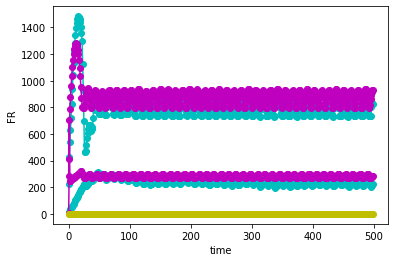

In [9]:
# RUN THE MODEL

time_start =0
time_end = 500

time_tot = 500

time_axis = np.arange(time_start,time_end)

intensity =0
pulse_len= 10
silence_per=2 #2 - same length as pulse

stim_sig = create_stim_sig(intensity,pulse_len,silence_per)
data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                        stim_13A = False,
                                        stim_SNs = True,
                                        record_data=True,
                                        display_movie=True) #DISPLAY MOVIE


A_vec_13A_rec_R = data_rec_dic["A_vec_13A_rec_R"]
A_vec_13A_rec_L = data_rec_dic["A_vec_13A_rec_L"]
A_vec_13B_rec_R = data_rec_dic["A_vec_13B_rec_R"]
A_vec_13B_rec_L = data_rec_dic["A_vec_13B_rec_L"]

HL_act_rec = data_rec_dic["HL_act_rec"]
MN_rec_L = data_rec_dic["MN_rec_L"]
MN_rec_R = data_rec_dic["MN_rec_R"]
SN_rec_L = data_rec_dic["SN_rec_L"]
SN_rec_R = data_rec_dic["SN_rec_R"]
out_excit_rec_L = data_rec_dic["out_excit_rec_L"] 
out_excit_rec_R = data_rec_dic["out_excit_rec_R"] 
out_excit_rec = data_rec_dic["out_excit_rec"] 
vel_rec =  data_rec_dic["vel_rec"]
angles_rec_L = data_rec_dic["angles_rec_L"] 
angles_rec_R = data_rec_dic["angles_rec_R"] 
joint_positions_XY_L_rec =  data_rec_dic["joint_positions_XY_L_rec"] 
joint_positions_XY_R_rec =  data_rec_dic["joint_positions_XY_R_rec"] 

W_mat_13A_L =  data_rec_dic["W_mat_13A_L"]
W_13A_MN_L = data_rec_dic["W_13A_MN_L"]
W_mat_SN_L = data_rec_dic["W_mat_SN_L"]
W_mat_SN_13A_L = data_rec_dic["W_mat_SN_13A_L"]
W_mat_SN_MNs_L = data_rec_dic["W_mat_SN_MNs_L"]
W_mat_13A_R =  data_rec_dic["W_mat_13A_R"]
W_13A_MN_R = data_rec_dic["W_13A_MN_R"]
W_mat_SN_R = data_rec_dic["W_mat_SN_R"]
W_mat_SN_13A_R = data_rec_dic["W_mat_SN_13A_R"]
W_mat_SN_MNs_R = data_rec_dic["W_mat_SN_MNs_R"]

W_sens_hidden = model_excit_net.W_sens_hidden
W_hidden = model_excit_net.W_hidden
W_hidden_out = model_excit_net.W_hidden_out


plt.plot(T(A_vec_13A_rec_L[0:6,time_start:time_end]),marker='o', color='c', linestyle='-')
plt.plot(T(A_vec_13A_rec_R[0:6,time_start:time_end]),marker='o', color='m', linestyle='-')


plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]*5),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")

print(dust_removed)
print(energy_loss)

Text(0, 0.5, 'FR')

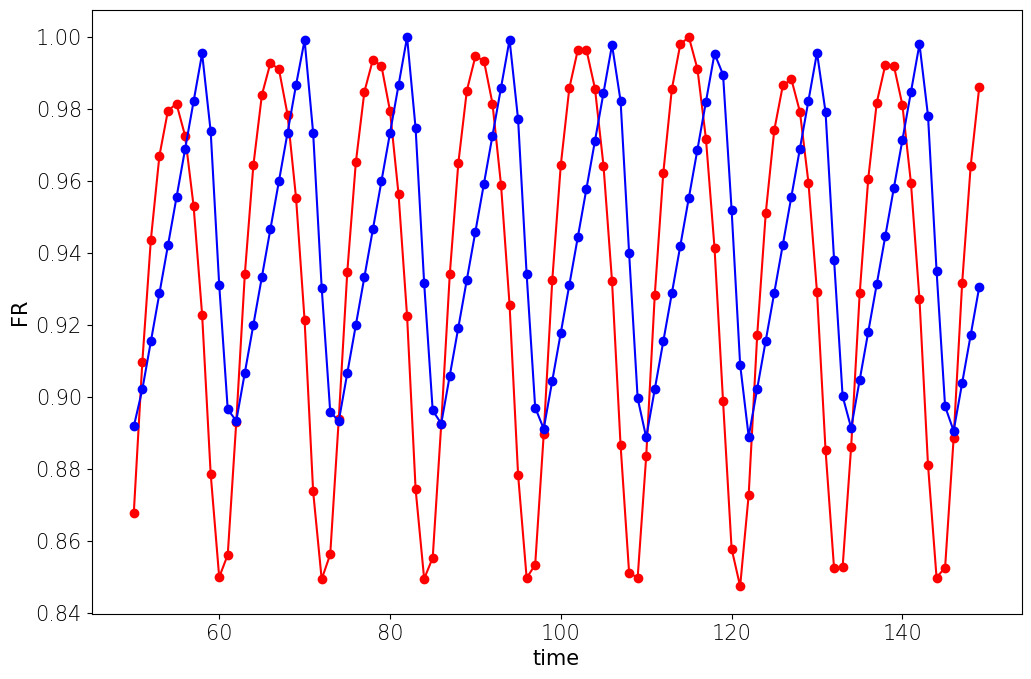

In [10]:

fig = plt.figure(figsize=(12, 8), dpi=100)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 15}
matplotlib.rc('font', **font)

time_start =50
time_end = 150

time_axis = np.arange(time_start,time_end)

feat1 = T(A_vec_13A_rec_L[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_L[1,time_start:time_end])

feat1 = T(A_vec_13A_rec_R[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_R[1,time_start:time_end])

feat1 = feat1/np.max(np.max(feat1))
feat2 = feat2/np.max(np.max(feat2))

plt.plot(time_axis,feat1,marker='o', color='r', linestyle='-')
plt.plot(time_axis,feat2,marker='o', color='b', linestyle='-')


plt.xlabel("time")
plt.ylabel("FR")

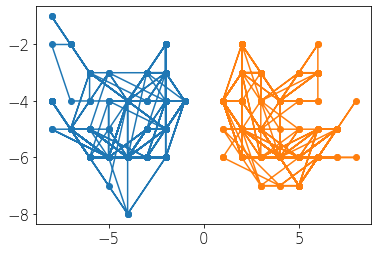

In [11]:
plt.plot(joint_positions_XY_L_rec[0,1,:],joint_positions_XY_L_rec[0,0,:],'-o')
plt.plot(joint_positions_XY_R_rec[0,1,:],joint_positions_XY_R_rec[0,0,:],'-o')

Text(0.5, 0, 'time')

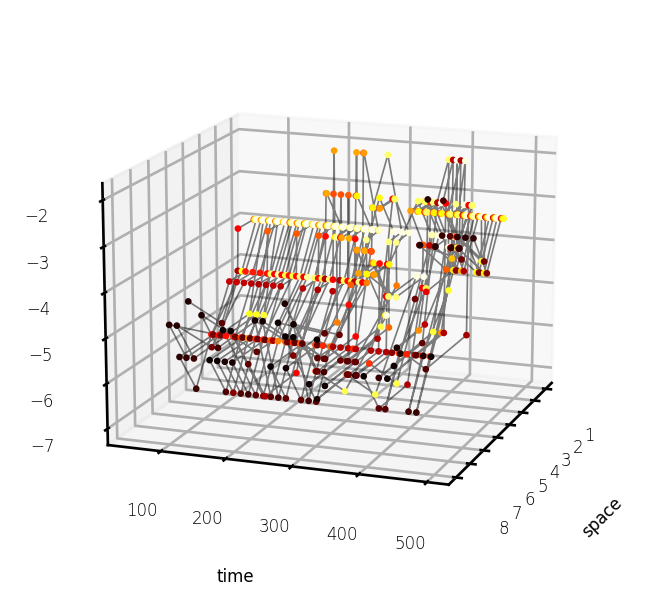

In [12]:

fig = plt.figure(figsize=(9, 3), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)

time_start =50
time_end = 500

time_axis = np.arange(time_start,time_end)

ax = plt.axes(projection='3d')

xdata=joint_positions_XY_L_rec[0,1,time_start:time_end]
zdata=joint_positions_XY_L_rec[0,0,time_start:time_end]
ydata=time_axis
col=T(A_vec_13A_rec_L[0,time_start:time_end])/np.max(np.max(T(A_vec_13A_rec_L[0,time_start:time_end])))

#ax.scatter3D(xdata, ydata, zdata, 'o', c=col, s=1, cmap='hot',alpha=1)
#ax.plot(xdata, ydata, zdata,'k-',linewidth=0.5,alpha=0.5)

xdata=joint_positions_XY_R_rec[0,1,time_start:time_end]
zdata=joint_positions_XY_R_rec[0,0,time_start:time_end]
ydata=time_axis
col=T(A_vec_13A_rec_R[1,time_start:time_end])/np.max(np.max(T(A_vec_13A_rec_R[1,time_start:time_end])))

ax.scatter3D(xdata, ydata, zdata, 'o', c=col, s=1, cmap='hot',alpha=1)
ax.plot(xdata, ydata, zdata,'k-',linewidth=0.5,alpha=0.5)

ax.view_init(15, 20)

plt.xlabel("space")
#plt.zlabel("space")
plt.ylabel("time")

0
1
2


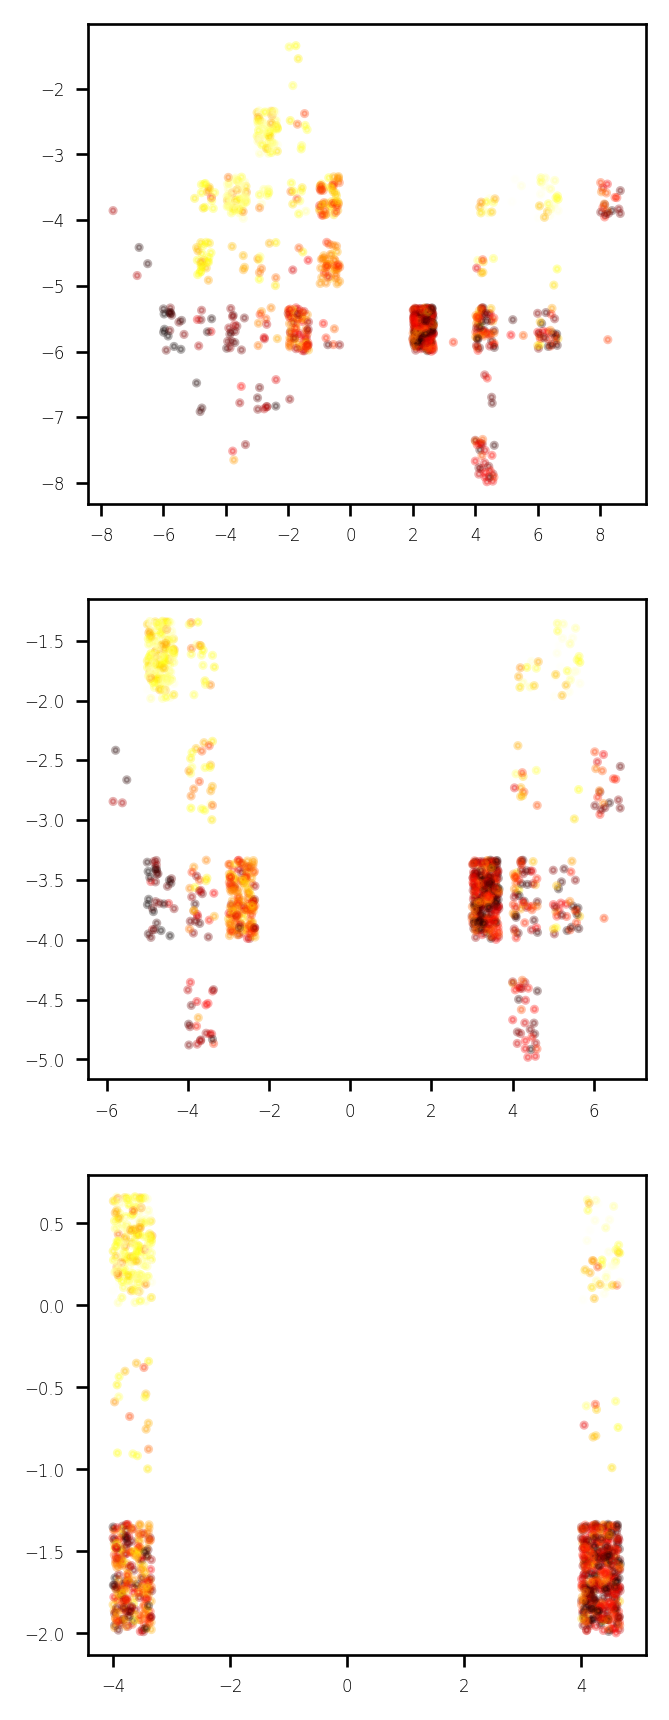

In [242]:


fig = plt.figure(figsize=(3, 9), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)

time_start =50
time_end = 500

time_axis = np.arange(time_start,time_end)

Nx = np.random.rand(1,time_end-time_start)/1.5
Ny = np.random.rand(1,time_end-time_start)/1.5

alph = 0.3


for j in range(0,3):
    
    print(j)
    plt.subplot(3,1,j+1)

    xdata=joint_positions_XY_L_rec[j,1,time_start:time_end]+Nx
    ydata=joint_positions_XY_L_rec[j,0,time_start:time_end]+Ny
    feature = T(A_vec_13A_rec_L[0,time_start:time_end])
    feature = feature - np.mean(feature)
    
    col= feature/np.max(np.max(feature))

    plt.scatter(xdata, ydata, s=3,marker='o', c=col, cmap='hot',alpha=alph)

    xdata=joint_positions_XY_R_rec[j,1,time_start:time_end]+Nx
    ydata=joint_positions_XY_R_rec[j,0,time_start:time_end]+Ny    
    feature = T(A_vec_13A_rec_R[0,time_start:time_end])
    feature = feature - np.mean(feature)
    
    col= feature/np.max(np.max(feature))
    

    plt.scatter(xdata, ydata, s=3,marker='o', c=col, cmap='hot',alpha=alph)


Text(0, 0.5, 'FR')

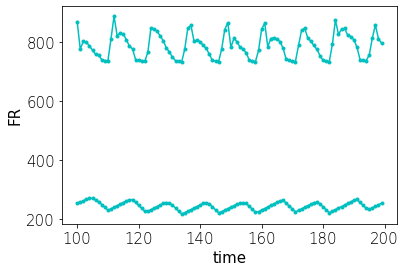

In [11]:
time_start =100
time_end = 200

time_axis = np.arange(time_start,time_end)



plt.plot(time_axis,T(A_vec_13A_rec_L[:,time_start:time_end]),marker='.', color='c', linestyle='-')


plt.xlabel("time")
plt.ylabel("FR")


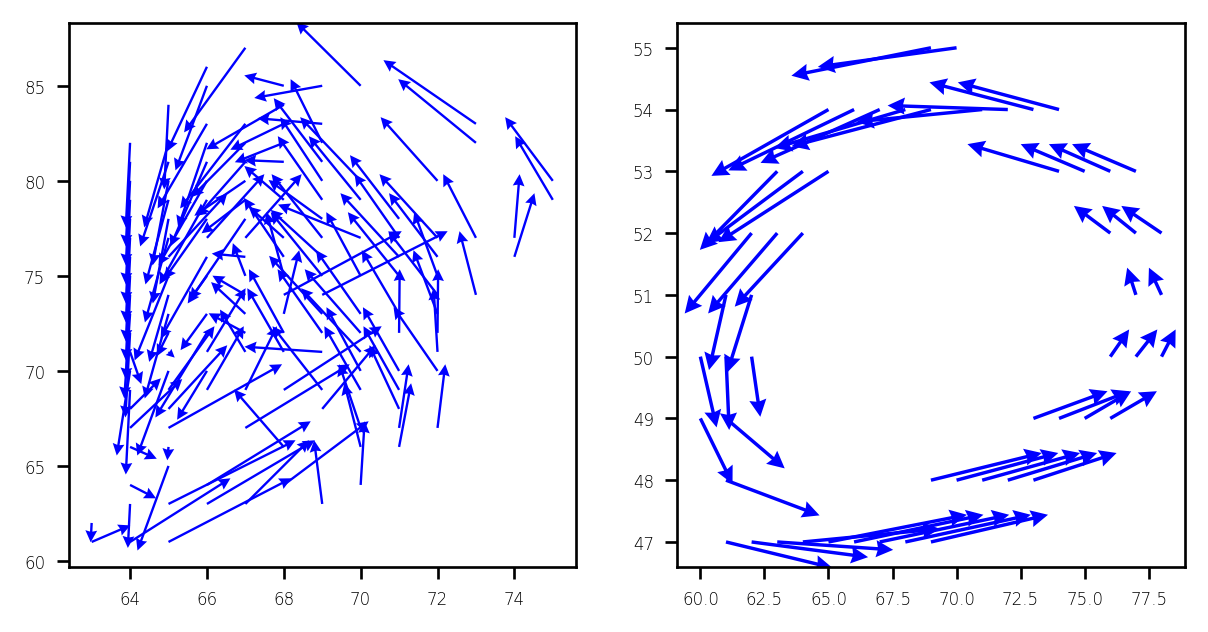

In [35]:

fig = plt.figure(figsize=(6, 3), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)

time_start =100
time_end = 500

#feat1 = T(A_vec_13A_rec_L[0,:]);range_y = [0, 100];range_x = [0, 100]
#feat2 = T(A_vec_13A_rec_L[1,:])

plt.subplot(1,2,1)  

feat1 = T(A_vec_13A_rec_L[0,:]);range_y = [0, 100];range_x = [0, 100]
feat2 = T(A_vec_13A_rec_L[1,:])

dd1_mat, dd2_mat = get_deriv_mat (feat1,feat2,time_start,time_end)

scale=0.01
width = 0.1

for x in range(range_x[0],range_x[1]):
    for y in range(range_y[0],range_y[1]):
        if A(dd1_mat[x, y]) > 0:
            plt.quiver(x, y, dd1_mat[x, y]*1, dd2_mat[x, y]*1, color='b', units='xy',  
                           scale=scale,width=width,headwidth=5,headlength=5) 
#plt.axis([0,100,0,100])             

plt.subplot(1,2,2)  

feat1 = T(A_vec_13A_rec_R[0,:]);range_y = [0, 100];range_x = [0, 100]
feat2 = T(A_vec_13A_rec_R[1,:])

dd1_mat, dd2_mat = get_deriv_mat (feat1,feat2,time_start,time_end)

scale=0.01
width = 0.1

for x in range(range_x[0],range_x[1]):
    for y in range(range_y[0],range_y[1]):
        if A(dd1_mat[x, y]) > 0:
            plt.quiver(x, y, dd1_mat[x, y]*1, dd2_mat[x, y]*1, color='b', units='xy',  
                           scale=scale,width=width,headwidth=5,headlength=5) 
            
#plt.axis([0,100,0,100])              

C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/812850469.py:23: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/812850469.py:39: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/812850469.py:60: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/812850469.py:75: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))


Text(0, 0.5, 'angle')

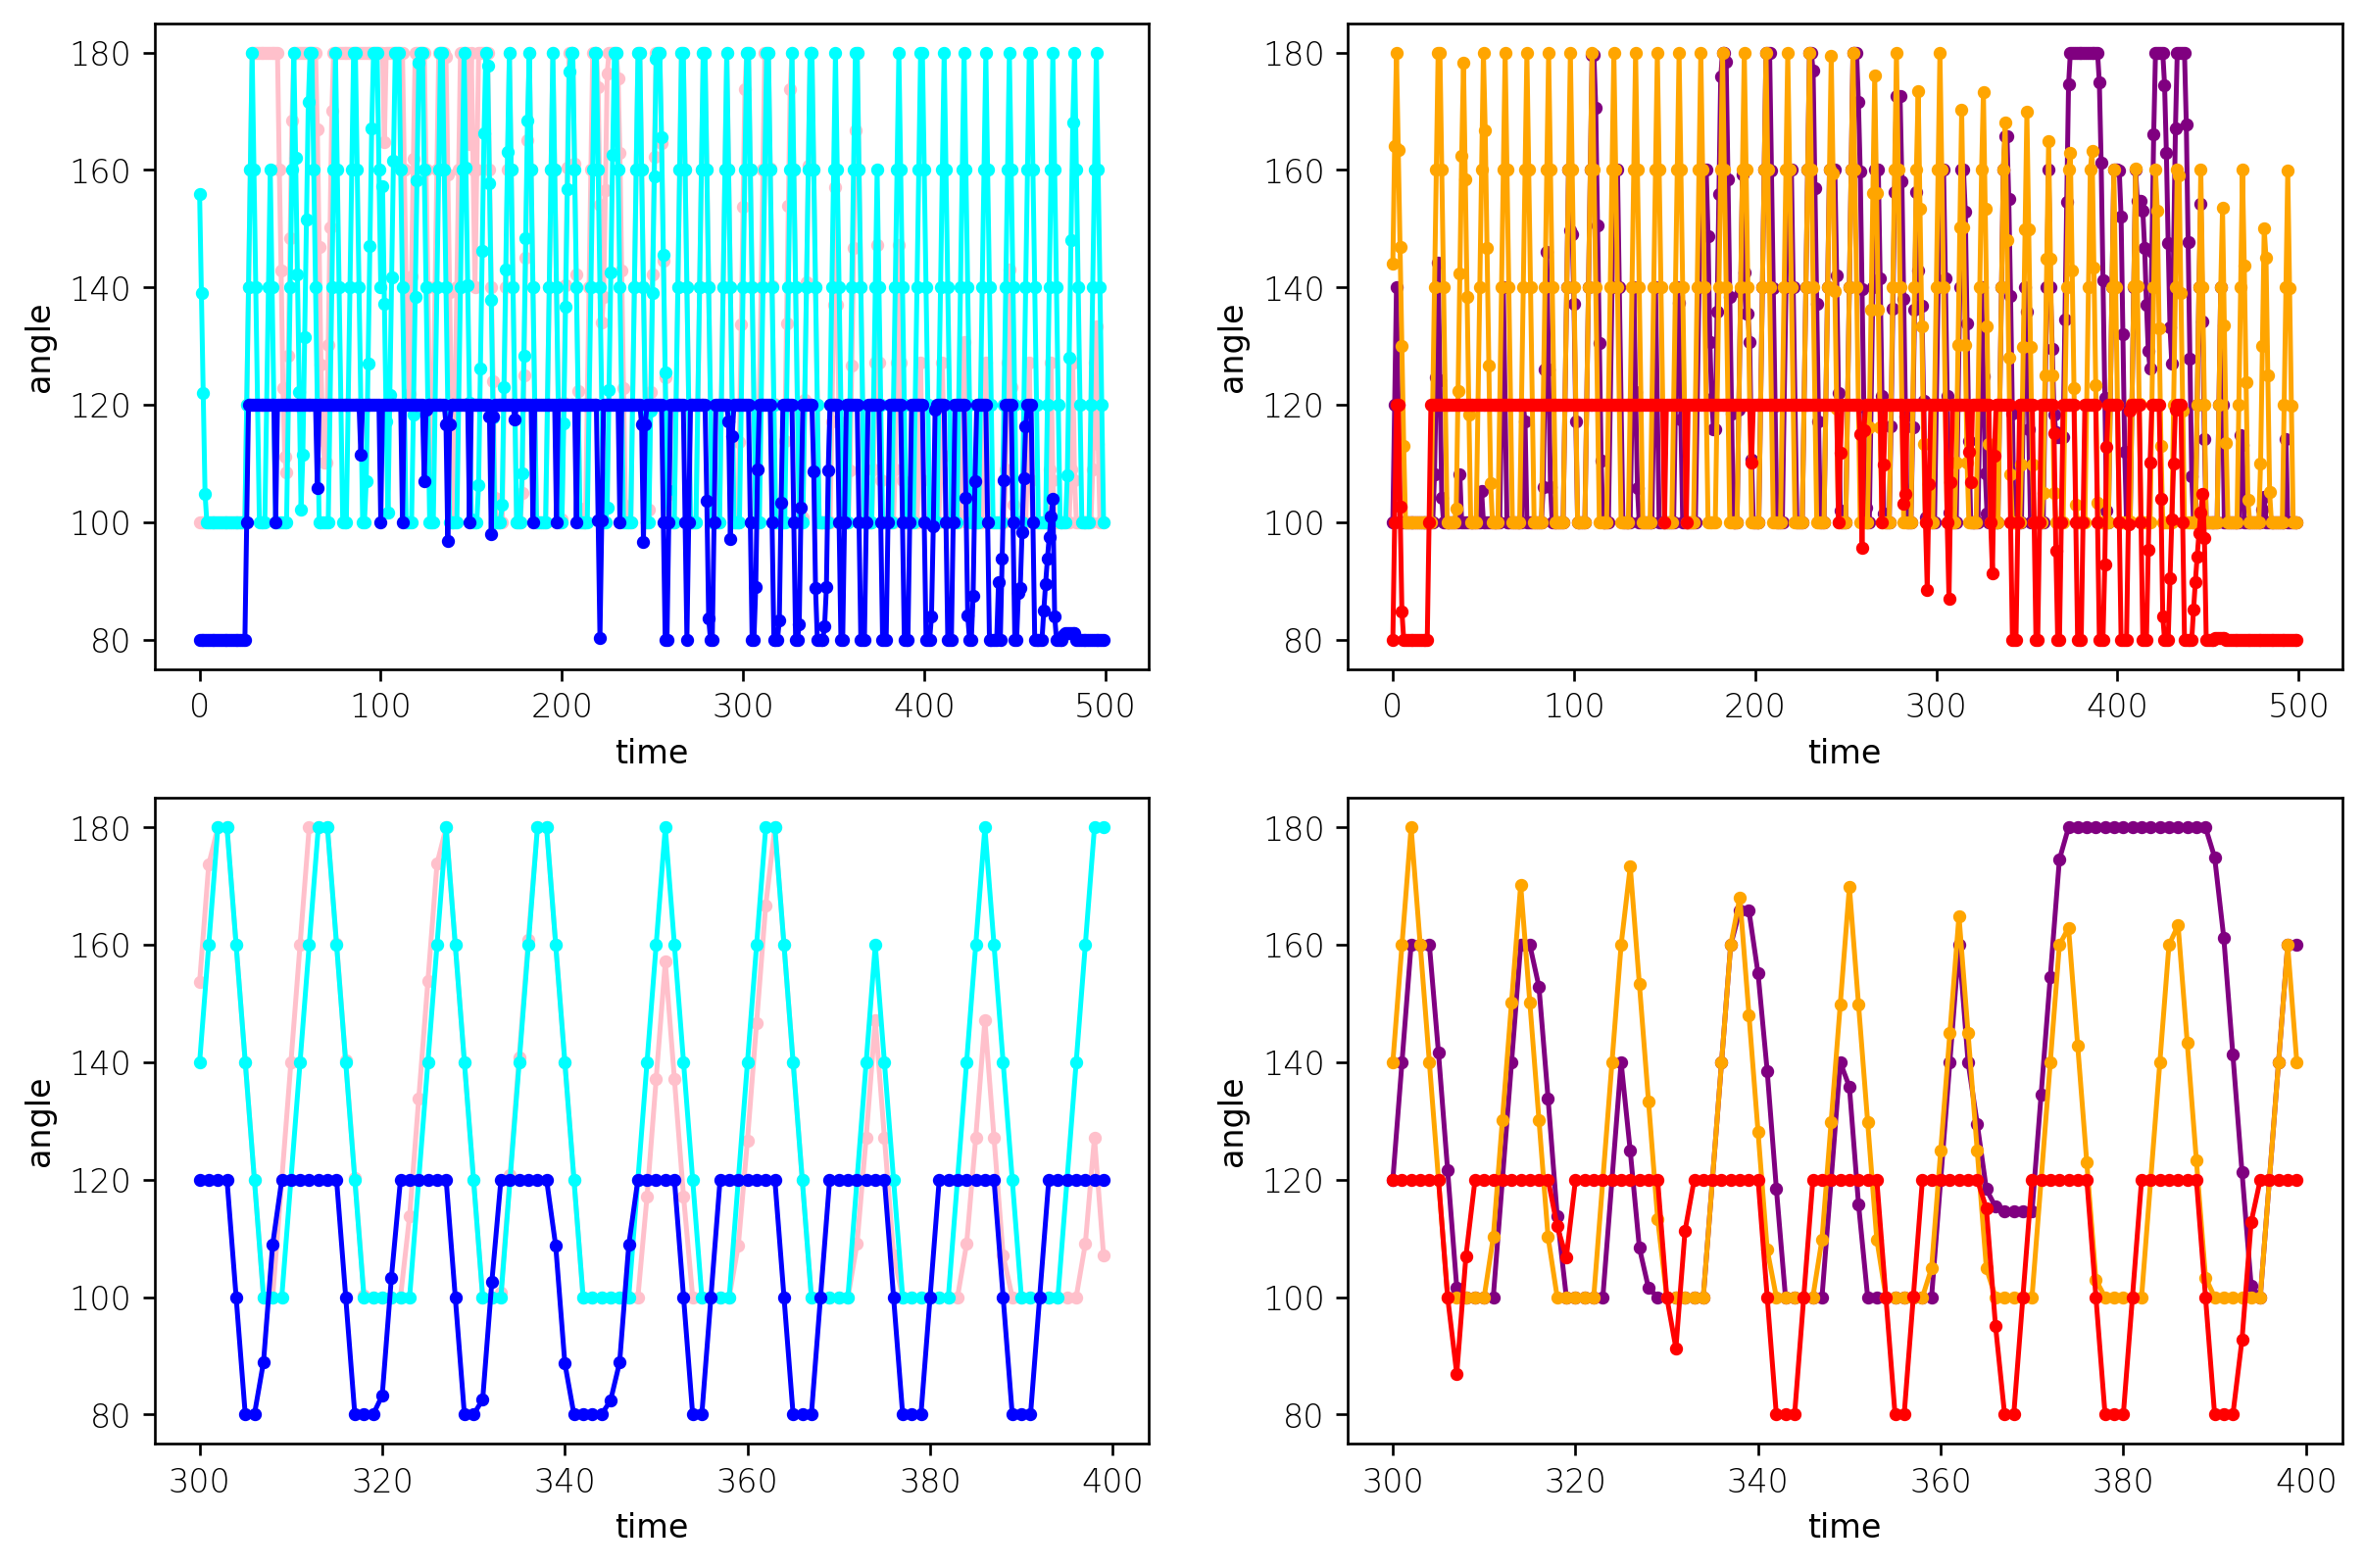

In [12]:

fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 10}
matplotlib.rc('font', **font)


time_start = 0
time_end = 500

time_axis = np.arange(time_start,time_end)

stim_on = True

plt.subplot(2,2,1)  

plt.plot(time_axis,T(angles_rec_L[0,time_start:time_end]),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[1,time_start:time_end]),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[2,time_start:time_end]),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angle")


plt.subplot(2,2,2)  

plt.plot(time_axis,T(angles_rec_R[0,time_start:time_end]),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[1,time_start:time_end]),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[2,time_start:time_end]),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angle")


plt.subplot(2,2,3)  

time_start = 300
time_end = 400

time_axis = np.arange(time_start,time_end)

plt.plot(time_axis,T(angles_rec_L[0,time_start:time_end]),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[1,time_start:time_end]),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[2,time_start:time_end]),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angle")

plt.subplot(2,2,4)  

plt.plot(time_axis,T(angles_rec_R[0,time_start:time_end]),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[1,time_start:time_end]),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[2,time_start:time_end]),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angle")

C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/737288656.py:24: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/737288656.py:40: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/737288656.py:61: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_22016/737288656.py:76: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))


Text(0, 0.5, 'angular velocity')

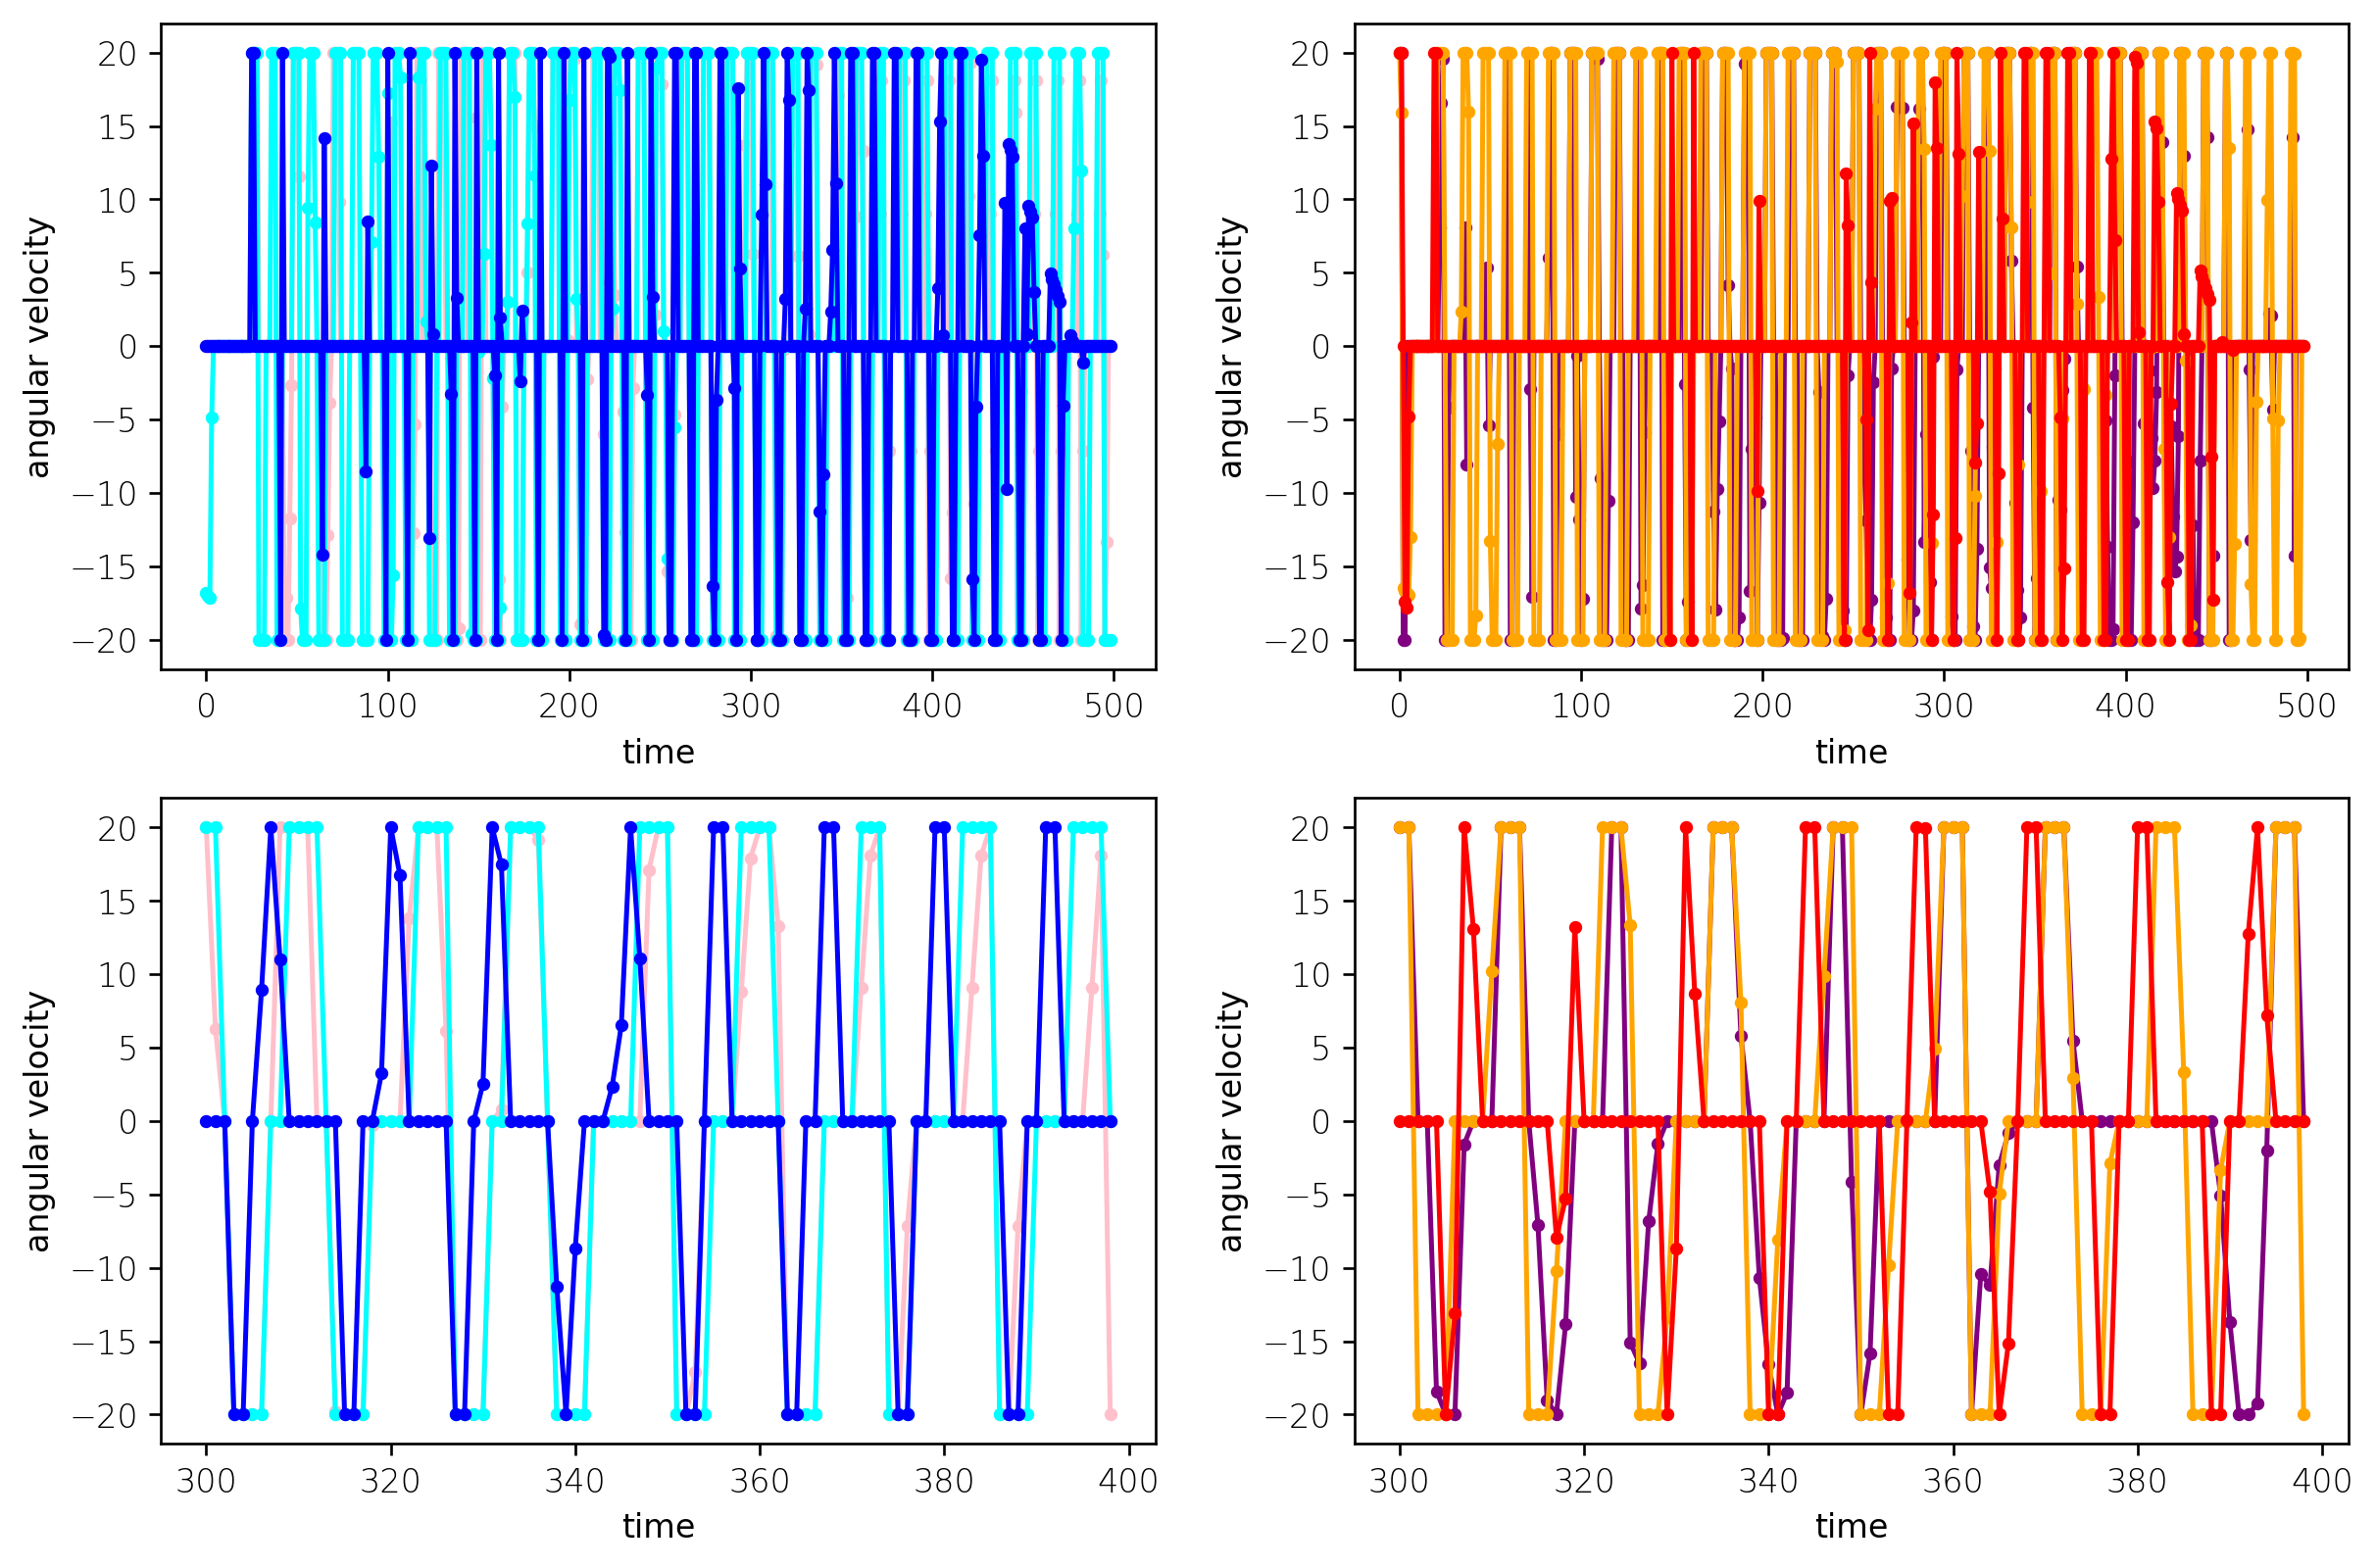

In [13]:

fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 10}
matplotlib.rc('font', **font)


time_start = 0
time_end = 500

time_axis = np.arange(time_start,time_end-1)

stim_on = True


plt.subplot(2,2,1)  

plt.plot(time_axis,T(np.diff(angles_rec_L[0,time_start:time_end])),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[1,time_start:time_end])),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[2,time_start:time_end])),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angular velocity")


plt.subplot(2,2,2)  

plt.plot(time_axis,T(np.diff(angles_rec_R[0,time_start:time_end])),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[1,time_start:time_end])),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[2,time_start:time_end])),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angular velocity")


plt.subplot(2,2,3)  

time_start = 300
time_end = 400

time_axis = np.arange(time_start,time_end-1)

plt.plot(time_axis,T(np.diff(angles_rec_L[0,time_start:time_end])),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[1,time_start:time_end])),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[2,time_start:time_end])),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angular velocity")

plt.subplot(2,2,4)  

plt.plot(time_axis,T(np.diff(angles_rec_R[0,time_start:time_end])),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[1,time_start:time_end])),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[2,time_start:time_end])),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("angular velocity")

Text(0, 0.5, 'FR')

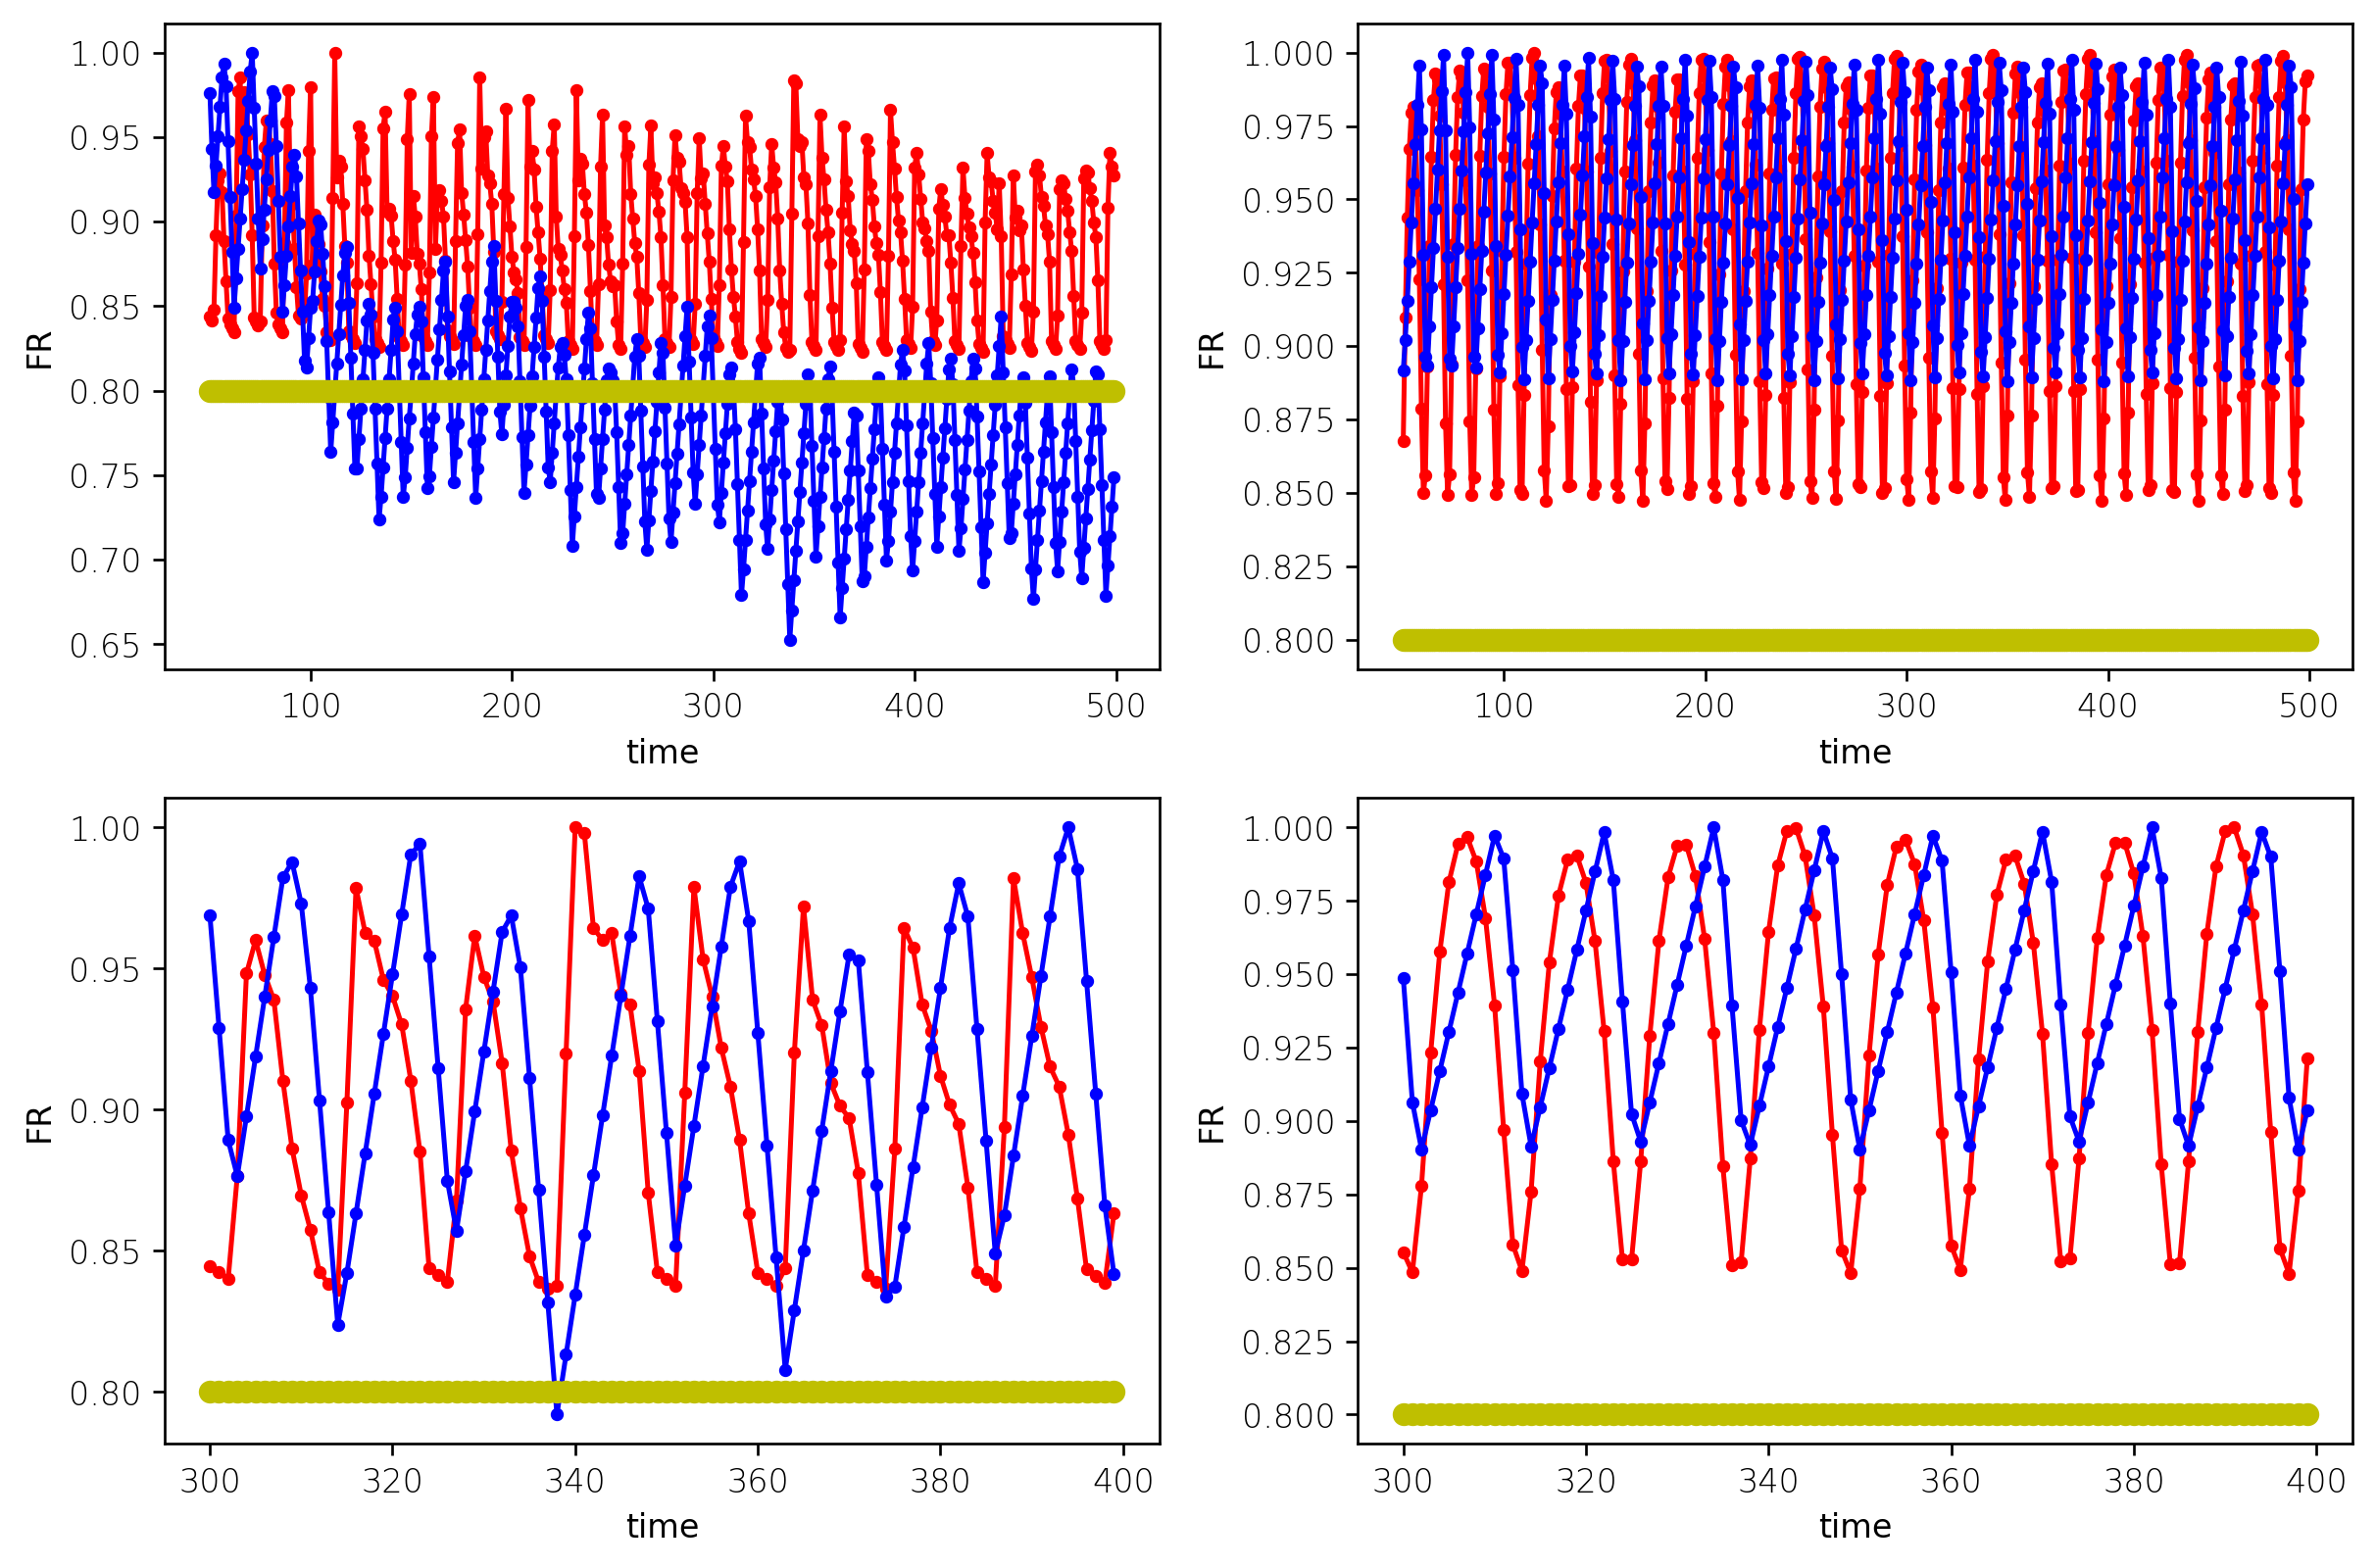

In [14]:

fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 10}
matplotlib.rc('font', **font)

stim_on = True

plt.subplot(2,2,1)

time_start =50
time_end = 500

time_axis = np.arange(time_start,time_end)

feat1 = T(A_vec_13A_rec_L[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_L[1,time_start:time_end])

feat1 = feat1/np.max(np.max(feat1))
feat2 = feat2/np.max(np.max(feat2))

plt.plot(time_axis,feat1,marker='.', color='r', linestyle='-')
plt.plot(time_axis,feat2,marker='.', color='b', linestyle='-')

if stim_on == True:
    plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]/100+0.8),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")


plt.subplot(2,2,2)  

feat1 = T(A_vec_13A_rec_R[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_R[1,time_start:time_end])

feat1 = feat1/np.max(np.max(feat1))
feat2 = feat2/np.max(np.max(feat2))

plt.plot(time_axis,feat1,marker='.', color='r', linestyle='-')
plt.plot(time_axis,feat2,marker='.', color='b', linestyle='-')


if stim_on == True:
    plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]/100+0.8),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")


plt.subplot(2,2,3)

time_start =300
time_end = 400

time_axis = np.arange(time_start,time_end)

feat1 = T(A_vec_13A_rec_L[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_L[1,time_start:time_end])

feat1 = feat1/np.max(np.max(feat1))
feat2 = feat2/np.max(np.max(feat2))

plt.plot(time_axis,feat1,marker='.', color='r', linestyle='-')
plt.plot(time_axis,feat2,marker='.', color='b', linestyle='-')


if stim_on == True:
    plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]/100+0.8),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")


plt.subplot(2,2,4)  

feat1 = T(A_vec_13A_rec_R[0,time_start:time_end])
feat2 = T(A_vec_13A_rec_R[1,time_start:time_end])

feat1 = feat1/np.max(np.max(feat1))
feat2 = feat2/np.max(np.max(feat2))

plt.plot(time_axis,feat1,marker='.', color='r', linestyle='-')
plt.plot(time_axis,feat2,marker='.', color='b', linestyle='-')


if stim_on == True:
    plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]/100+0.8),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")

In [16]:

#create pulses of various lengths - ep_range

time_start =50
time_end = 500

time_tot =500

left_leg = True

ep_range = [2,100] #pulse length range
feat_cube = np.zeros((ep_range[1],time_tot,23))
mean_feat_rec = np.zeros((ep_range[1],23))

raster_13A_0_L = np.zeros((ep_range[1],time_end-time_start))
raster_13A_1_L = np.zeros((ep_range[1],time_end-time_start))

freq_spect_rec = np.zeros((ep_range[1],time_end-time_start))
#freq_spect_rec = np.zeros((ep_range[1],50))


for e_p in range(ep_range[0],ep_range[1]):
    
    #intensity = 0
    #intensity =  e_p/10
    #intensity =  10
    intensity =  5
    
    pulse_len=e_p
    #pulse_len=5
    
    silence_per=2 #2 - same length as pulse

    stim_sig = create_stim_sig(intensity,pulse_len,silence_per)


    data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                            stim_13A = False,
                                            stim_SNs = True,
                                            record_data=True,
                                            display_movie=False)


    A_vec_13A_rec_R = data_rec_dic["A_vec_13A_rec_R"]
    A_vec_13A_rec_L = data_rec_dic["A_vec_13A_rec_L"]
    HL_act_rec = data_rec_dic["HL_act_rec"]
    MN_rec_L = data_rec_dic["MN_rec_L"]
    MN_rec_R = data_rec_dic["MN_rec_R"]
    SN_rec_L = data_rec_dic["SN_rec_L"]
    SN_rec_R = data_rec_dic["SN_rec_R"]
    out_excit_rec_L = data_rec_dic["out_excit_rec_L"] 
    out_excit_rec_R = data_rec_dic["out_excit_rec_R"] 
    vel_rec =  data_rec_dic["vel_rec"]
    angles_rec_L = data_rec_dic["angles_rec_L"] 
    angles_rec_R = data_rec_dic["angles_rec_R"] 

    if left_leg == True:
    
        feat_cube[e_p,:,0] = stim_sig
        feat_cube[e_p,:,1:4] = T(angles_rec_L)
        feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_L),np.zeros((3,1)) )) ) 
        feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_L)/np.max(np.max(A_vec_13A_rec_L))
        feat_cube[e_p,:,9:15] = T(MN_rec_L)
        
        raster_13A_0_L[e_p,:] = A_vec_13A_rec_L[0,time_start:time_end]
        raster_13A_1_L[e_p,:] = A_vec_13A_rec_L[1,time_start:time_end]
    
    if left_leg == False:
    
        feat_cube[e_p,:,0] = stim_sig
        feat_cube[e_p,:,1:4] = T(angles_rec_R)
        feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_R),np.zeros((3,1)) )) ) 
        feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_R)/np.max(np.max(A_vec_13A_rec_R))
        feat_cube[e_p,:,9:15] = T(MN_rec_R)
    
    #sig=T(angles_rec_L[0,:])
    #sig=feat_cube[e_p,:,6] #prox ang. vel
    sig=feat_cube[e_p,:,4] #distal ang. vel
    #sig=feat_cube[e_p,:,0] #stim sig
    sig = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(sig,axis=1)), [0, 0], order=0, mode='constant')
    #ft = np.absolute(np.fft.fft(sig,time_end-time_start))
    ft = np.absolute(np.fft.fft(sig,time_end-time_start))
    ft = ft/np.max(ft)
    #ft = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(ft,axis=1)), [0, 0], order=0, mode='constant')
    ft = scipy.ndimage.filters.gaussian_filter(ft, [0, 0], order=0, mode='constant')
    max_pow_freq = np.argmax(ft[0,10:250]==np.max(ft[0,10:250]))
    freq_spect_rec[e_p,:]=ft 
    
    mean_feat_rec[e_p,1] = max_pow_freq 
    mean_feat_rec[e_p,2] = np.mean(vel_rec[0,:])
    
    print(e_p)



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


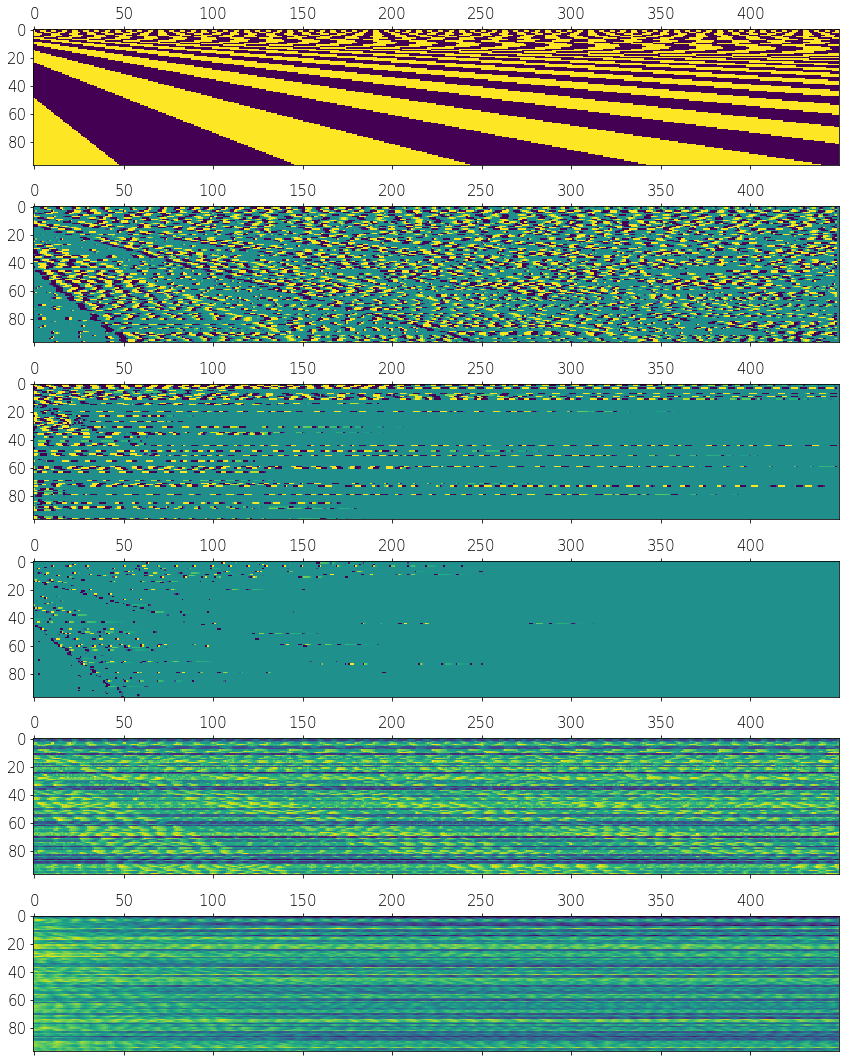

In [17]:
ex_start = 2
ex_end = 99

time_start=50
time_end=500

plot_feat_ind = [0,4,5,6,7,8]

fig, axs = plt.subplots(6, 1, figsize=(12, 15))

# Plot each matrix in a subplot
for i in range(6):
    ind = plot_feat_ind[i] 
    axs[i].matshow(feat_cube[ex_start:ex_end, time_start:time_end, ind], aspect='auto')

plt.tight_layout()
plt.show()

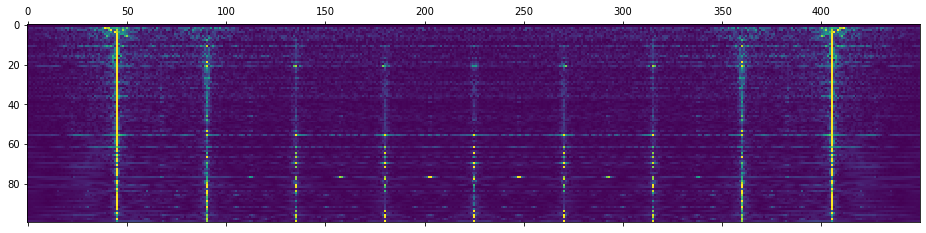

In [70]:
plt.matshow(freq_spect_rec,aspect='auto')

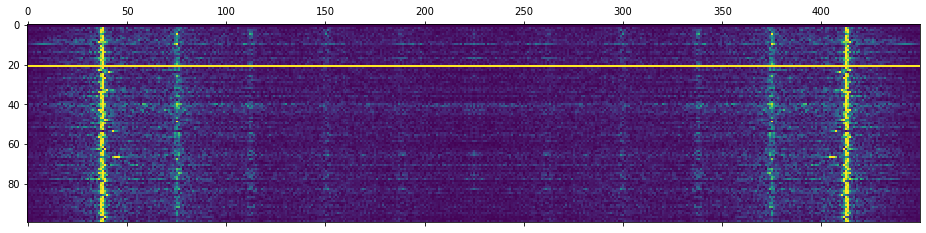

In [60]:
plt.matshow(freq_spect_rec,aspect='auto')

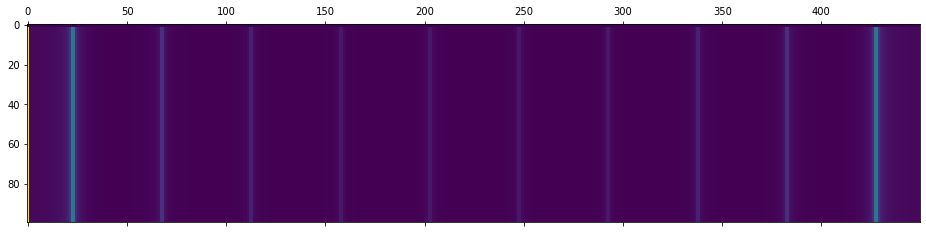

In [66]:
plt.matshow(freq_spect_rec,aspect='auto')

In [30]:

time_start =50
time_end = 500

time_tot =500

left_leg = True

ep_range = [2,100] #pulse length range
ei_range = [2,300] #pulse intensity range
feat_cube = np.zeros((ep_range[1],time_tot,23))
mean_feat_rec = np.zeros((ep_range[1],23))

raster_13A_0_L = np.zeros((ep_range[1],time_end-time_start))
raster_13A_1_L = np.zeros((ep_range[1],time_end-time_start))

freq_spect_rec = np.zeros((ep_range[1],time_end-time_start))
#freq_spect_rec = np.zeros((ep_range[1],50))

p_vs_i_freq_mat = np.zeros((ep_range[1],ep_range[1]))


for e_p,pulse_len in enumerate(np.arange(ep_range[0],ep_range[1])):
    for e_i,intensity in enumerate(np.arange(ei_range[0],ei_range[1],3)):
    
        intensity =  intensity/10
        #intensity =  0

        #pulse_len=e_p
        silence_per=2 #2 - same length as pulse

        stim_sig = create_stim_sig(intensity,pulse_len,silence_per)


        data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                                stim_13A = False,
                                                stim_SNs = True,
                                                record_data=True,
                                                display_movie=False)


        A_vec_13A_rec_R = data_rec_dic["A_vec_13A_rec_R"]
        A_vec_13A_rec_L = data_rec_dic["A_vec_13A_rec_L"]
        HL_act_rec = data_rec_dic["HL_act_rec"]
        MN_rec_L = data_rec_dic["MN_rec_L"]
        MN_rec_R = data_rec_dic["MN_rec_R"]
        SN_rec_L = data_rec_dic["SN_rec_L"]
        SN_rec_R = data_rec_dic["SN_rec_R"]
        out_excit_rec_L = data_rec_dic["out_excit_rec_L"] 
        out_excit_rec_R = data_rec_dic["out_excit_rec_R"] 
        vel_rec =  data_rec_dic["vel_rec"]
        angles_rec_L = data_rec_dic["angles_rec_L"] 
        angles_rec_R = data_rec_dic["angles_rec_R"] 

        if left_leg == True:

            feat_cube[e_p,:,0] = stim_sig
            feat_cube[e_p,:,1:4] = T(angles_rec_L)
            feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_L),np.zeros((3,1)) )) ) 
            feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_L)/np.max(np.max(A_vec_13A_rec_L))
            feat_cube[e_p,:,9:15] = T(MN_rec_L)

            raster_13A_0_L[e_p,:] = A_vec_13A_rec_L[0,time_start:time_end]
            raster_13A_1_L[e_p,:] = A_vec_13A_rec_L[1,time_start:time_end]

        if left_leg == False:

            feat_cube[e_p,:,0] = stim_sig
            feat_cube[e_p,:,1:4] = T(angles_rec_R)
            feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_R),np.zeros((3,1)) )) ) 
            feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_R)/np.max(np.max(A_vec_13A_rec_R))
            feat_cube[e_p,:,9:15] = T(MN_rec_R)

        #sig=T(angles_rec_L[0,:])
        #sig=feat_cube[e_p,:,6] #prox ang. vel
        sig=feat_cube[e_p,:,4] #distal ang. vel
        sig = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(sig,axis=1)), [0, 0], order=0, mode='constant')
        #ft = np.absolute(np.fft.fft(sig,time_end-time_start))
        ft = np.absolute(np.fft.fft(sig,time_end-time_start))
        ft = ft/np.max(ft)
        #ft = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(ft,axis=1)), [0, 0], order=0, mode='constant')
        ft = scipy.ndimage.filters.gaussian_filter(ft, [0, 0], order=0, mode='constant')
        max_pow_freq = np.argmax(ft[0,10:250]==np.max(ft[0,10:250]))
        freq_spect_rec[e_p,:]=ft 
        
        p_vs_i_freq_mat[e_p,e_i]=max_pow_freq

        mean_feat_rec[e_p,1] = max_pow_freq 
        mean_feat_rec[e_p,2] = np.mean(vel_rec[0,:])

    print(e_p)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


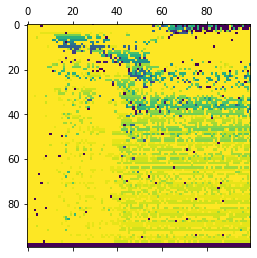

In [45]:
diff_mat = ((np.zeros((100,100))+28) - p_vs_i_freq_mat)
diff_mat[diff_mat<0] = 0
plt.matshow(-diff_mat,aspect='auto')